In [1]:
import torch
import argparse
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from avalanche.benchmarks.classic import SplitMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins.early_stopping import EarlyStoppingPlugin
from avalanche.training.supervised import Naive
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    loss_metrics,
    timing_metrics,
    cpu_usage_metrics,
    confusion_matrix_metrics,
    disk_usage_metrics,
    CumulativeAccuracyPluginMetric,
    CumulativeForgettingPluginMetric,
    ExperienceMaxRAM,
    ExperienceMaxGPU
)
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, EarlyStoppingPlugin

import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
# Device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SimpleMLP(num_classes=10)

benchmark = SplitMNIST(n_experiences=5, seed = 1, fixed_class_order=list(range(10)))

# Than we can extract the parallel train and test streams
train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

# Prepare for training & testing
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


# Evaluation metric
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        loss_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        timing_metrics(epoch=False, epoch_running=True),
        forgetting_metrics(experience=True, stream=True),
        cpu_usage_metrics(experience=True),
        confusion_matrix_metrics(
            num_classes=10, save_image=True, absolute_class_order= True, stream=True
        ),
        CumulativeAccuracyPluginMetric(),
        CumulativeForgettingPluginMetric(),
        ExperienceMaxGPU(gpu_id=0),
        ExperienceMaxRAM(),
        disk_usage_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        loggers=[TextLogger(open('out.txt', 'w')), interactive_logger]
    )
BATCH_SIZE= 1024

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 100232432.19it/s]


Extracting /home/jovyan/.avalanche/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/jovyan/.avalanche/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 10805074.82it/s]

Extracting /home/jovyan/.avalanche/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/jovyan/.avalanche/data/mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 19581997.07it/s]

Extracting /home/jovyan/.avalanche/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/jovyan/.avalanche/data/mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2807328.14it/s]


Extracting /home/jovyan/.avalanche/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/jovyan/.avalanche/data/mnist/MNIST/raw



/opt/conda/lib/python3.11/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


In [6]:
def reset_parameters(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [3]:
for id, experience in enumerate(train_stream):
  print(f"Task {experience.task_label}")
  print(f"Classes in this experience {experience.classes_in_this_experience}")
  dataset = experience.dataset
  print(f"Train data contains {len(dataset)} patterns. With benchmark {train_stream.benchmark}")
  # for x, y, t in dataset:
  #   pass

  test_experience = test_stream[id]
  cumulative_test = test_stream[:id+1]
  print(f"Test data contains {len(test_experience.dataset)}")

Task 0
Classes in this experience [0, 1]
Train data contains 12665 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x799218fc61d0>
Test data contains 2115
Task 0
Classes in this experience [2, 3]
Train data contains 12089 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x799218fc61d0>
Test data contains 2042
Task 0
Classes in this experience [4, 5]
Train data contains 11263 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x799218fc61d0>
Test data contains 1874
Task 0
Classes in this experience [6, 7]
Train data contains 12183 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x799218fc61d0>
Test data contains 1986
Task 0
Classes in this experience [8, 9]
Train data contains 11800 patterns. With benchmark <avalanche.benchmarks.scenar

/opt/conda/lib/python3.11/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)




Current Classes:  [0, 1]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00,  4.56it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 41.0477
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 172.1504
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.3040
	MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0397


/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x7992176edd50>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 172.1504
	Loss_Stream/eval_phase/test_stream/Task000 = 2.3040
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0397
100%|██████████| 13/13 [00:01<00:00,  7.17it/s]
Epoch 0 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0238
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00, 13.31it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 97.8634
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 172.1504
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6469
	MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Tas

/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x799211407e50>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.0000
	CumulativeForgetting/eval_phase/test_stream/Exp000 = 0.9953
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 188.0391
	Loss_Stream/eval_phase/test_stream/Task000 = 6.7301
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0000
100%|██████████| 12/12 [00:01<00:00,  7.29it/s]
Epoch 0 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0270
-- >> Start of eval phase << --
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:00<00:00,  8.99it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp001 = 104.6327
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp001 = 221.5840
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 1.3

/opt/conda/lib/python3.11/site-packages/avalanche/evaluation/metric_utils.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x799210fff110>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.0000
	CumulativeAccuracy/eval_phase/test_stream/Exp001 = 0.9500
	CumulativeForgetting/eval_phase/test_stream/Exp000 = 0.9953
	CumulativeForgetting/eval_phase/test_stream/Exp001 = -0.3888
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 229.5635
	Loss_Stream/eval_phase/test_stream/Task000 = 0.1748
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.9500
100%|██████████| 12/12 [00:01<00:00,  7.69it/s]
Epoch 5 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0119
-- >> Start of eval phase << --
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:00<00:00,  8.82it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp001 = 101.5

/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x79920af08ad0>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.0000
	CumulativeAccuracy/eval_phase/test_stream/Exp001 = 0.0000
	CumulativeForgetting/eval_phase/test_stream/Exp000 = 0.9953
	CumulativeForgetting/eval_phase/test_stream/Exp001 = 0.5612
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 362.7988
	Loss_Stream/eval_phase/test_stream/Task000 = 8.4649
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0000
100%|██████████| 11/11 [00:01<00:00,  8.86it/s]
Epoch 0 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0120
-- >> Start of eval phase << --
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp002 = 100.12

/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x799209773ed0>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.0000
	CumulativeAccuracy/eval_phase/test_stream/Exp001 = 0.0000
	CumulativeAccuracy/eval_phase/test_stream/Exp002 = 0.0000
	CumulativeForgetting/eval_phase/test_stream/Exp000 = 0.9953
	CumulativeForgetting/eval_phase/test_stream/Exp001 = 0.5612
	CumulativeForgetting/eval_phase/test_stream/Exp002 = 0.0021
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 410.6074
	Loss_Stream/eval_phase/test_stream/Task000 = 8.6918
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0000
100%|██████████| 12/12 [00:01<00:00,  8.24it/s]
Epoch 0 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0208
-- >> Start of eval phase << --
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 2/2 [00:00<00:00,  9.32it

/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x7992080b7290>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.0000
	CumulativeAccuracy/eval_phase/test_stream/Exp001 = 0.0000
	CumulativeAccuracy/eval_phase/test_stream/Exp002 = 0.0000
	CumulativeAccuracy/eval_phase/test_stream/Exp003 = 0.0000
	CumulativeForgetting/eval_phase/test_stream/Exp000 = 0.9953
	CumulativeForgetting/eval_phase/test_stream/Exp001 = 0.5612
	CumulativeForgetting/eval_phase/test_stream/Exp002 = 0.0021
	CumulativeForgetting/eval_phase/test_stream/Exp003 = 0.0695
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 538.0908
	Loss_Stream/eval_phase/test_stream/Task000 = 9.0531
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0000
100%|██████████| 12/12 [00:01<00:00,  8.68it/s]
Epoch 0 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0111
-- >> Start of e

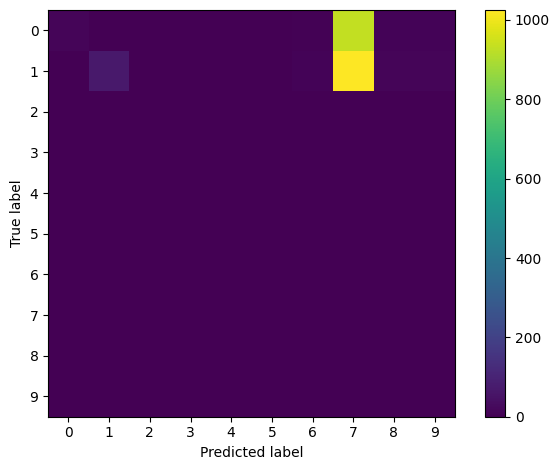

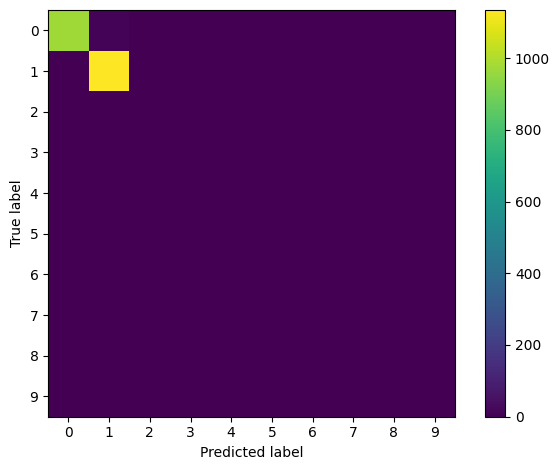

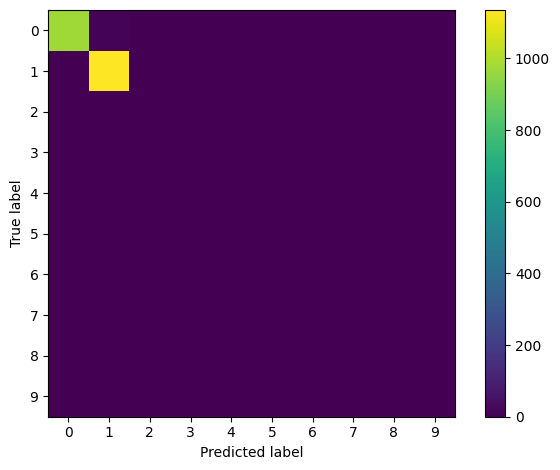

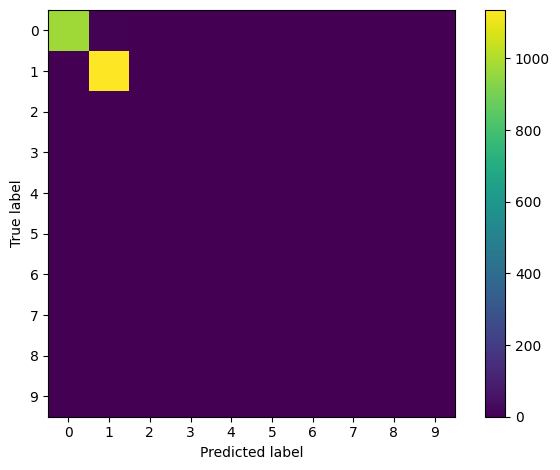

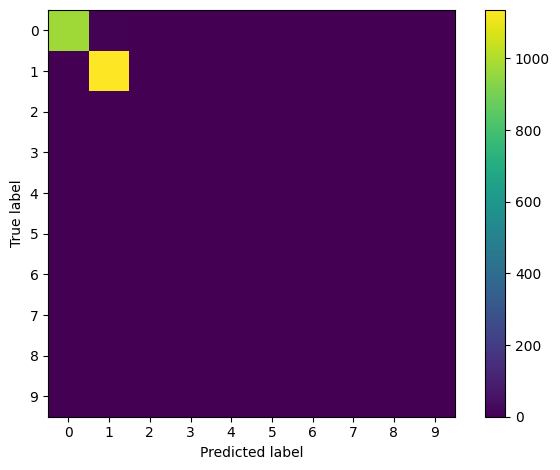

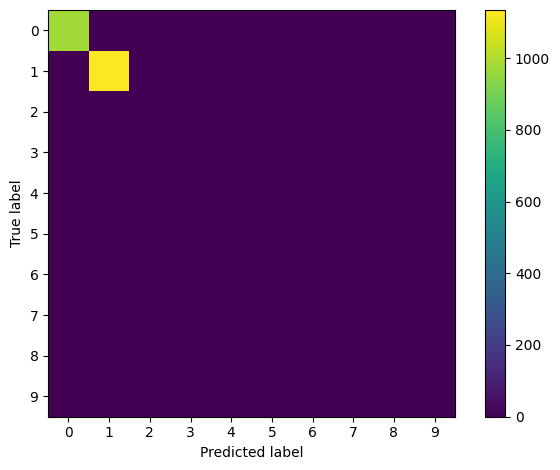

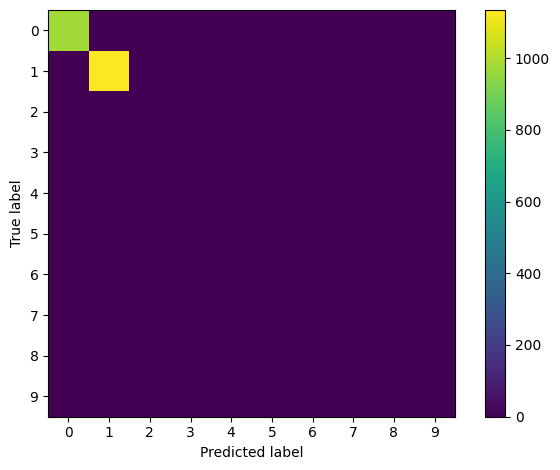

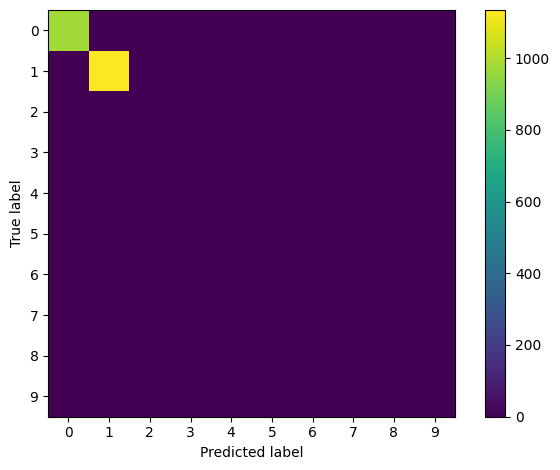

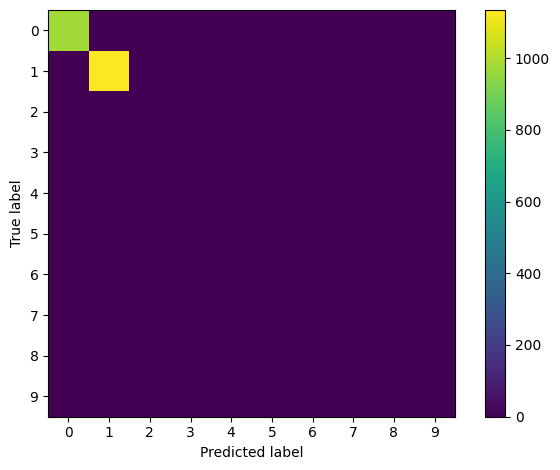

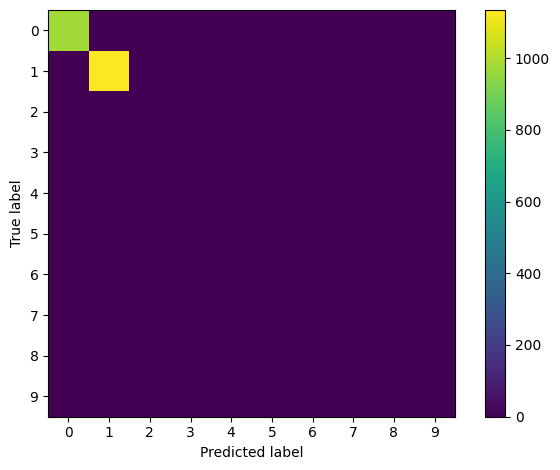

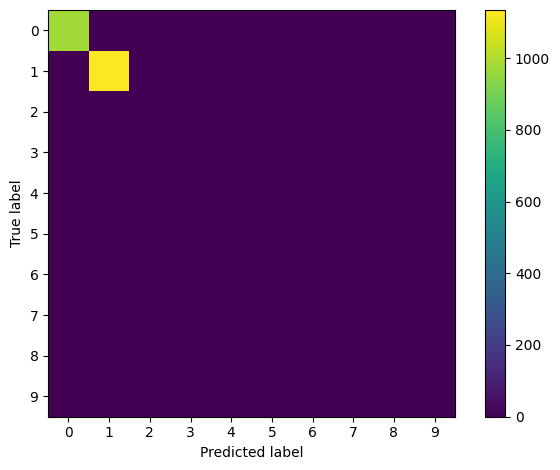

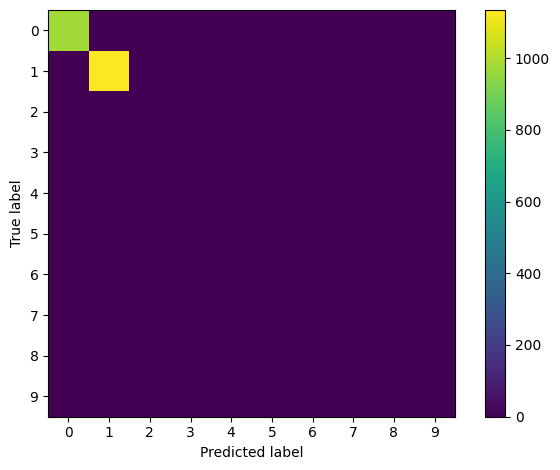

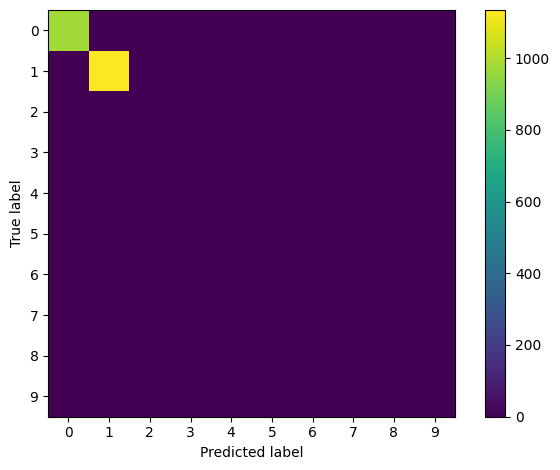

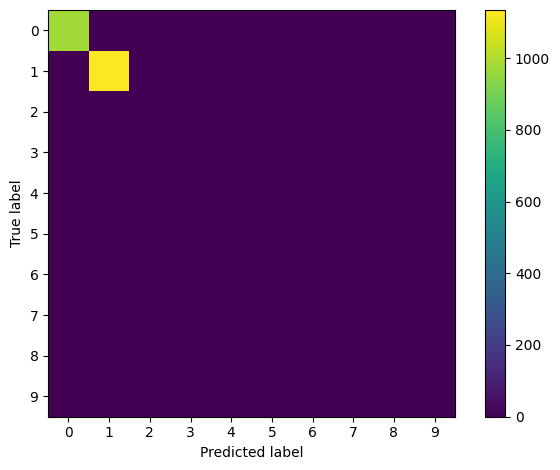

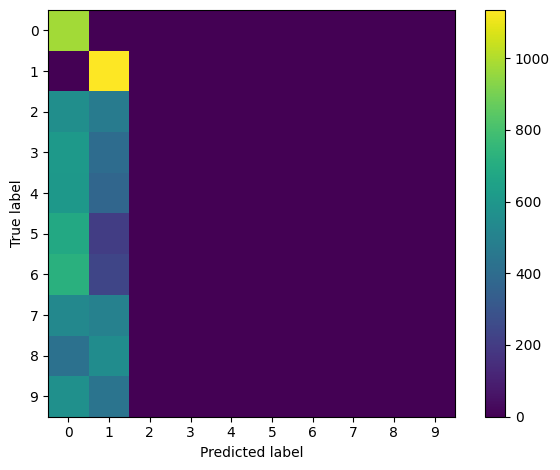

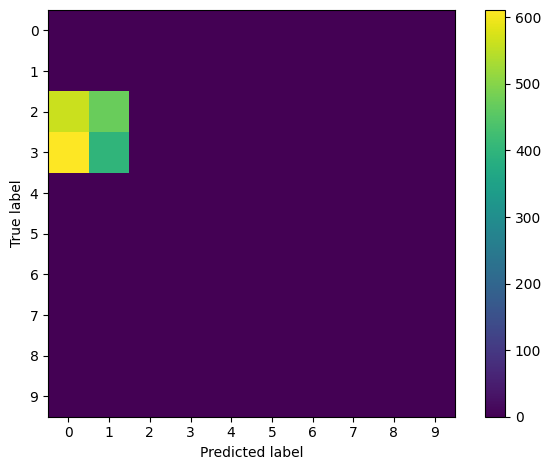

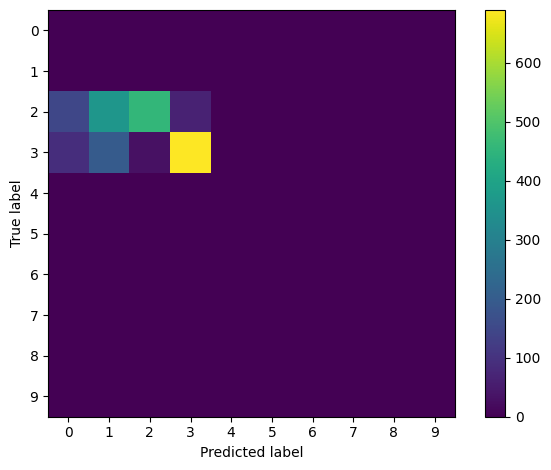

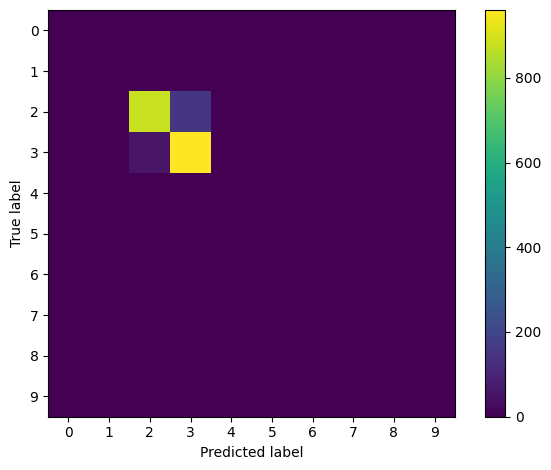

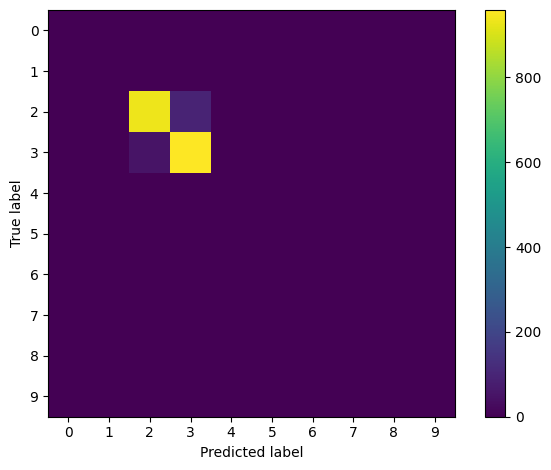

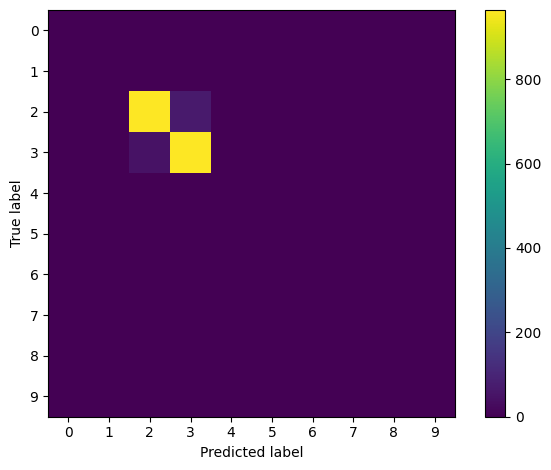

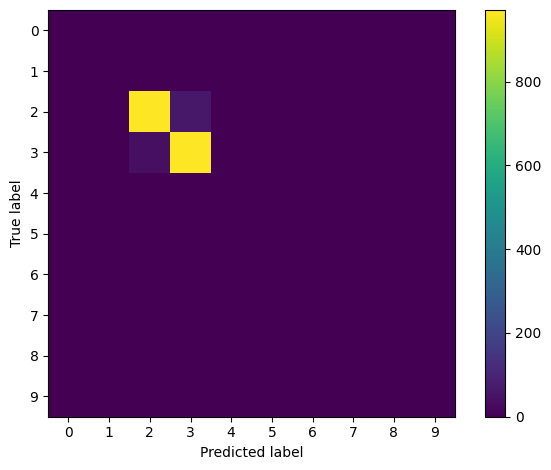

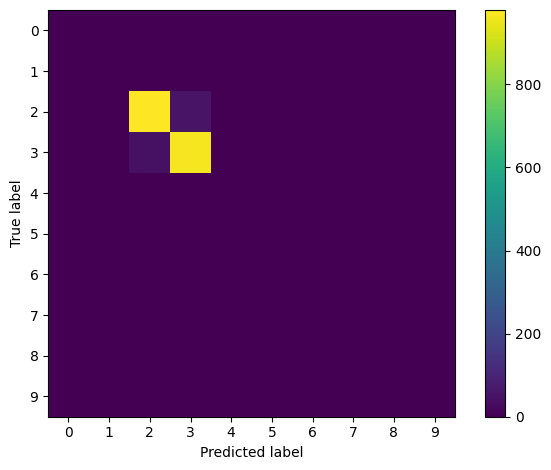

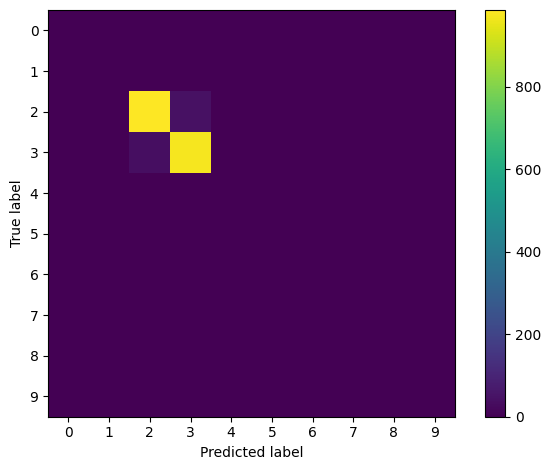

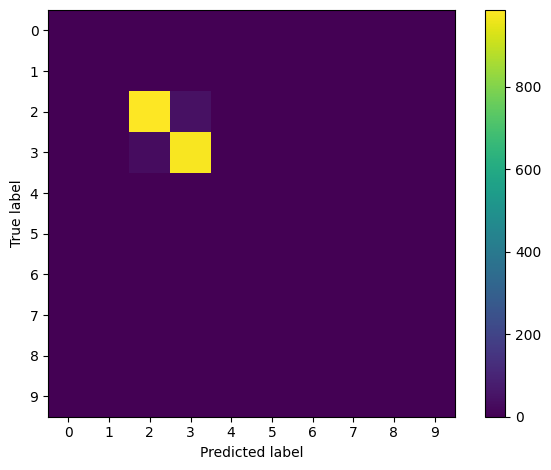

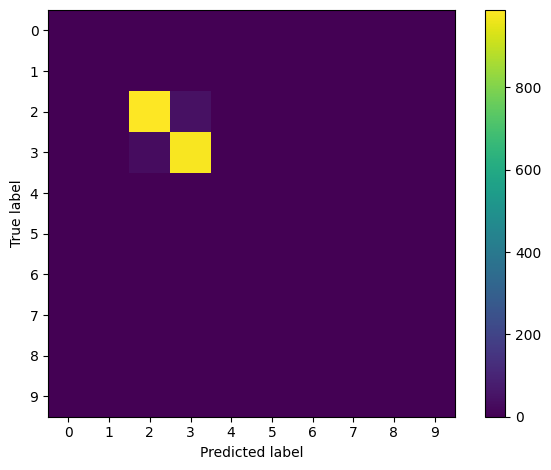

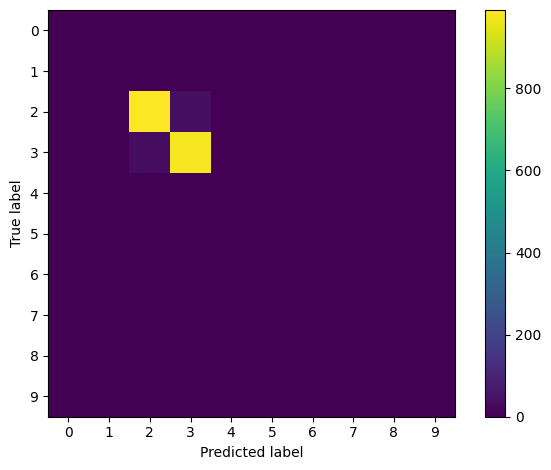

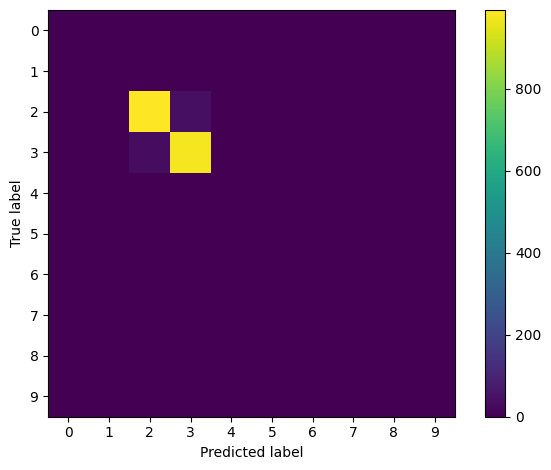

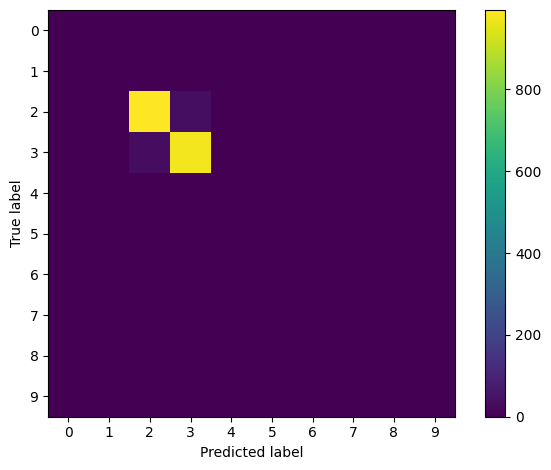

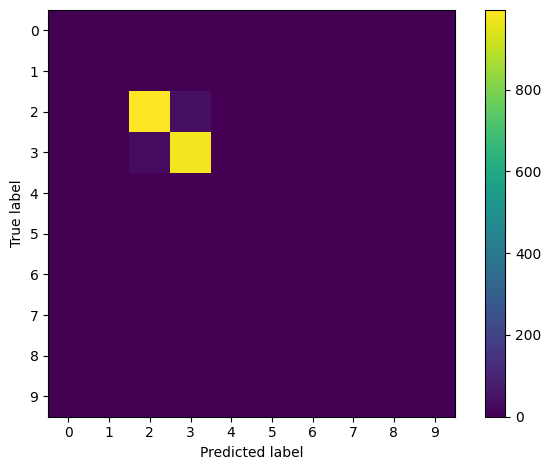

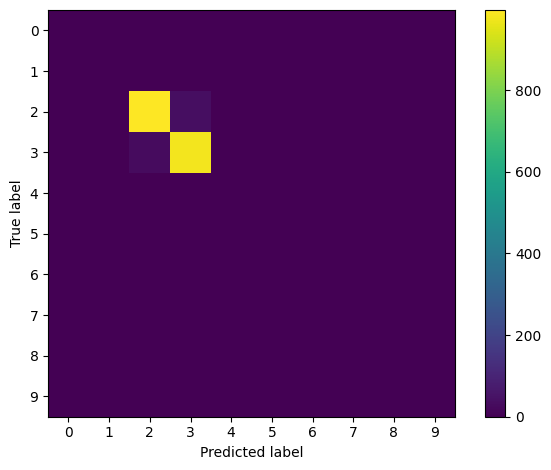

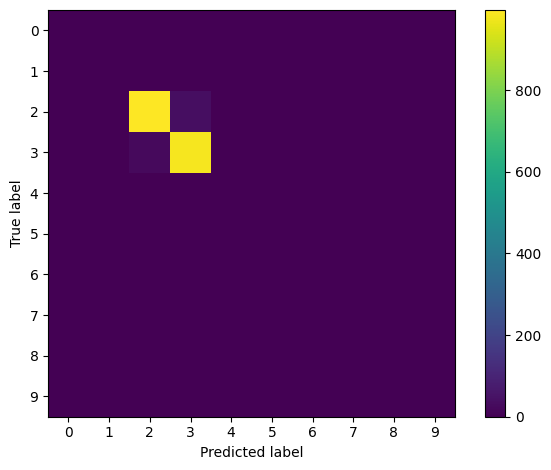

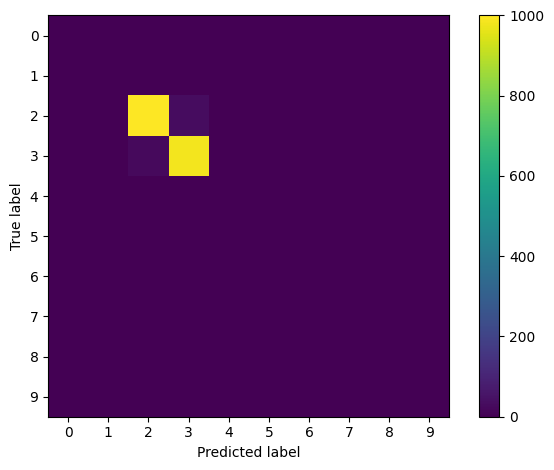

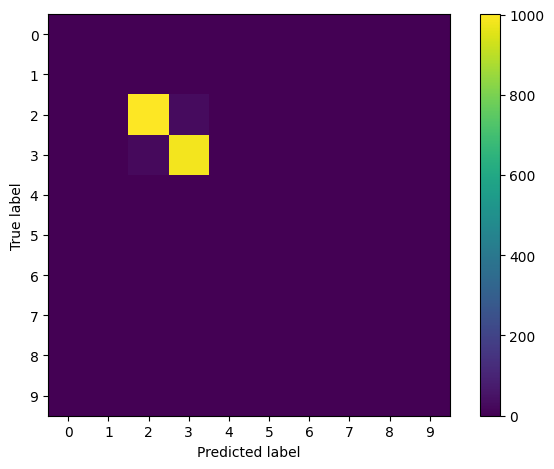

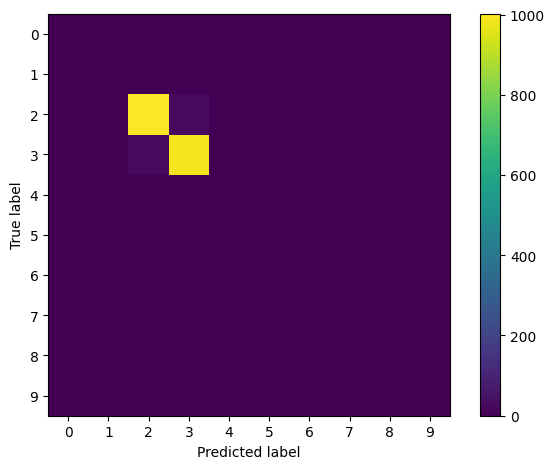

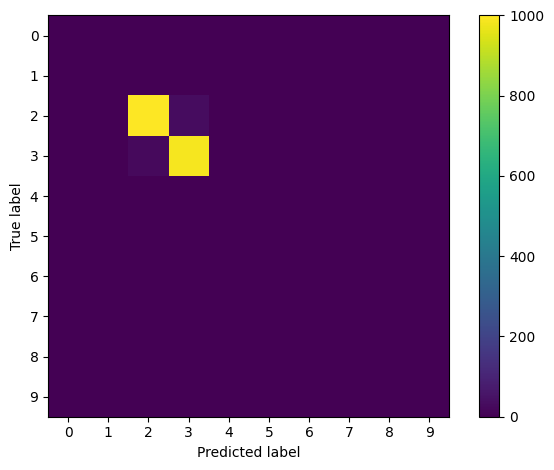

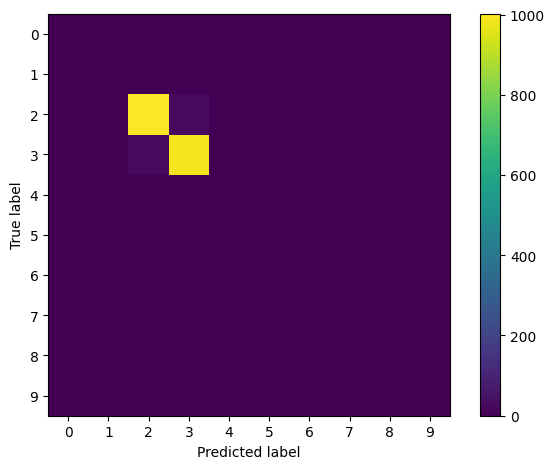

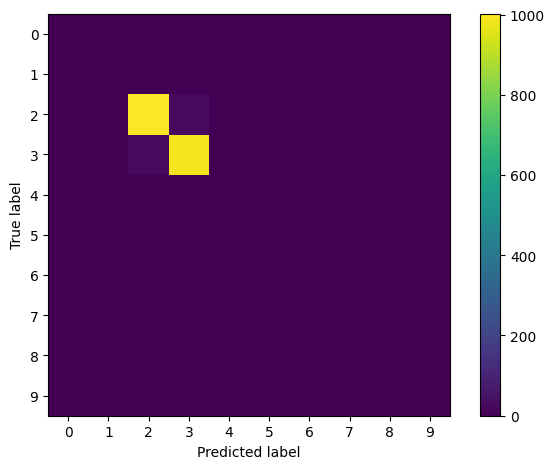

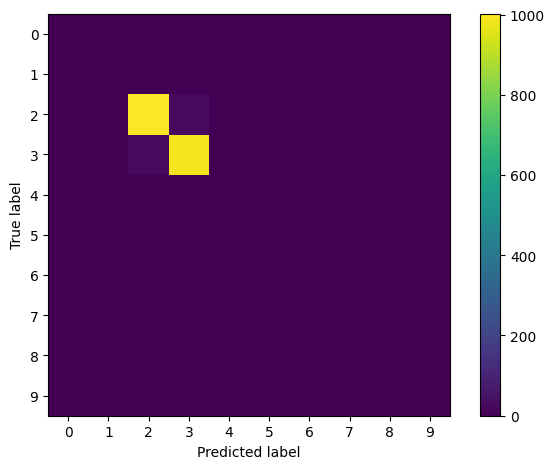

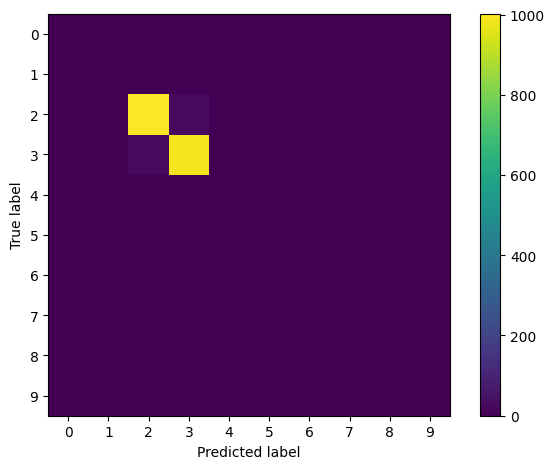

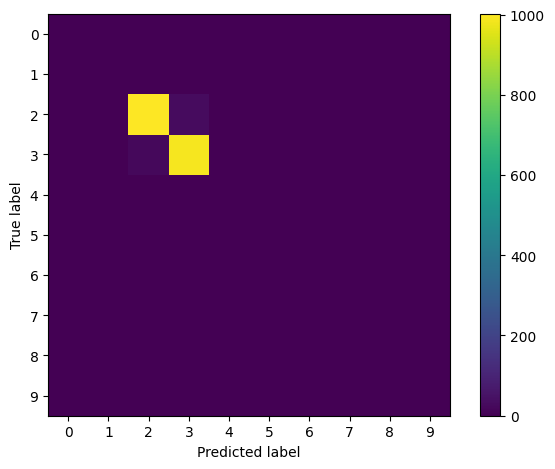

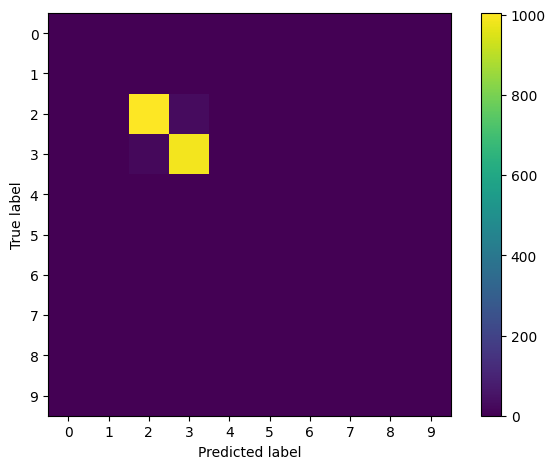

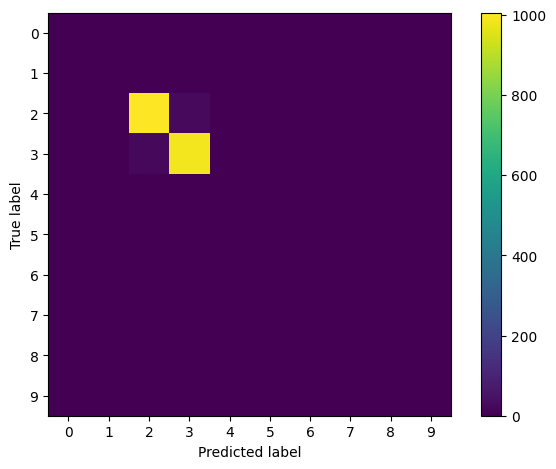

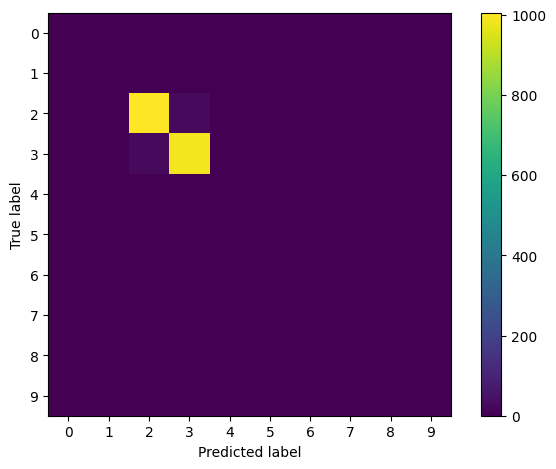

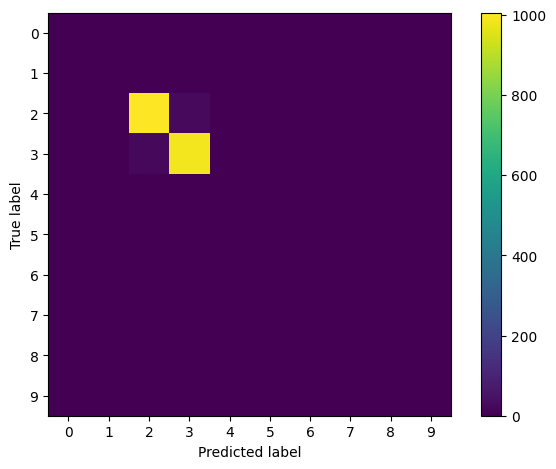

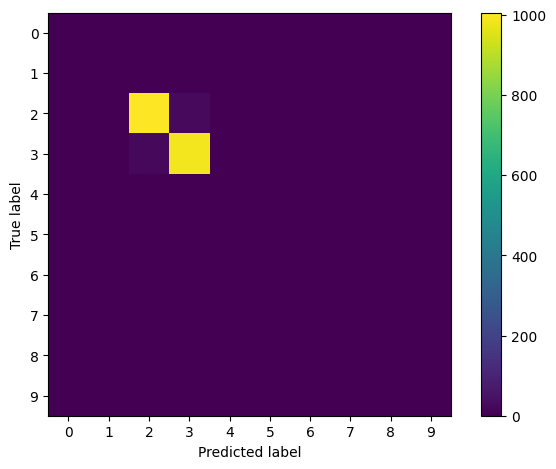

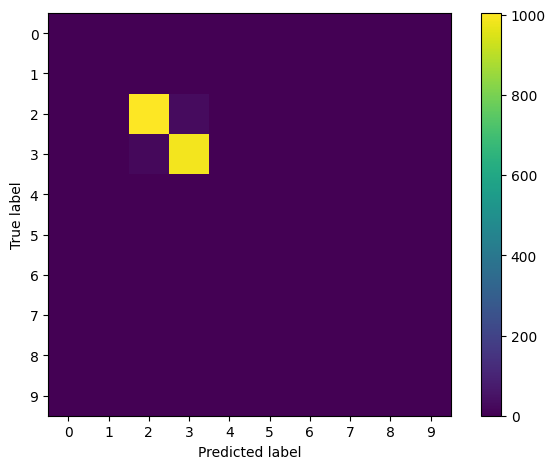

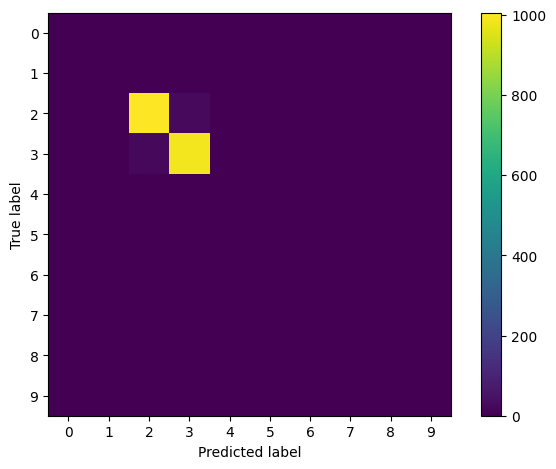

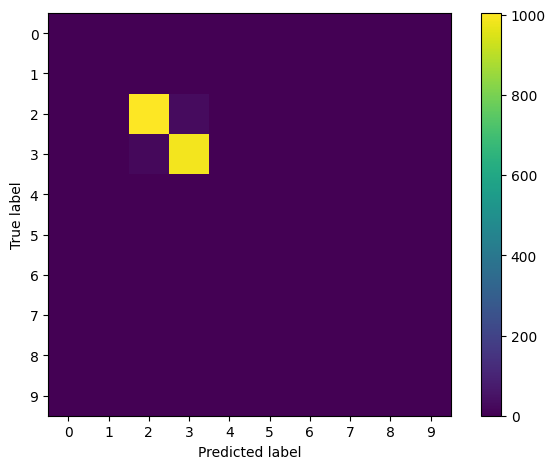

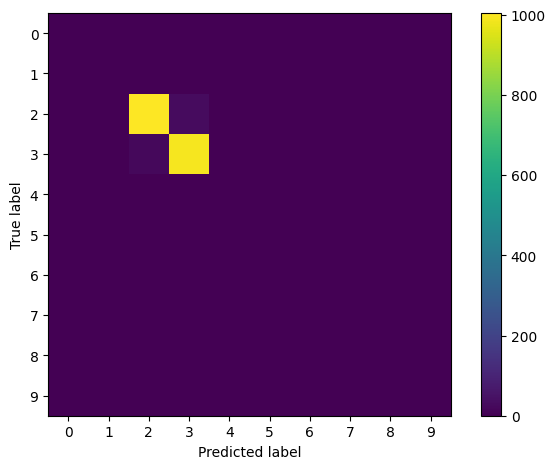

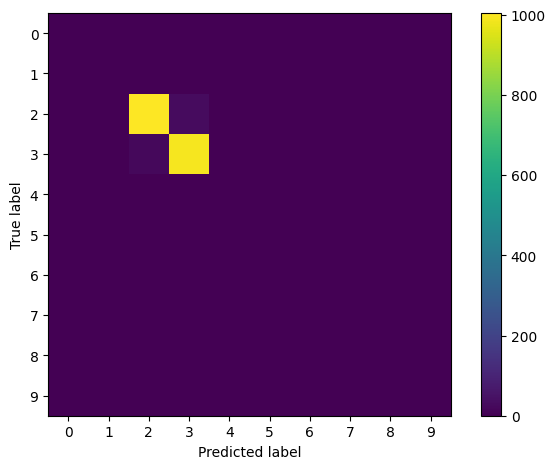

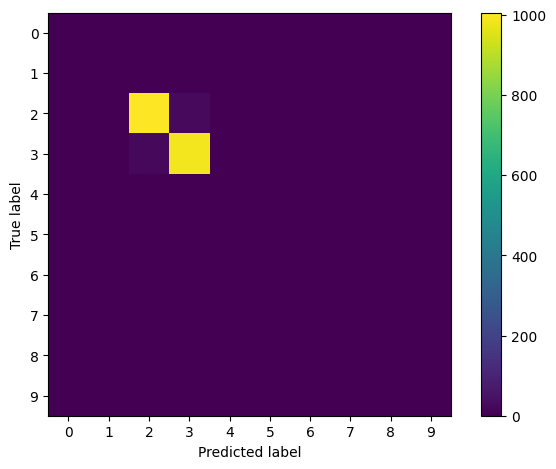

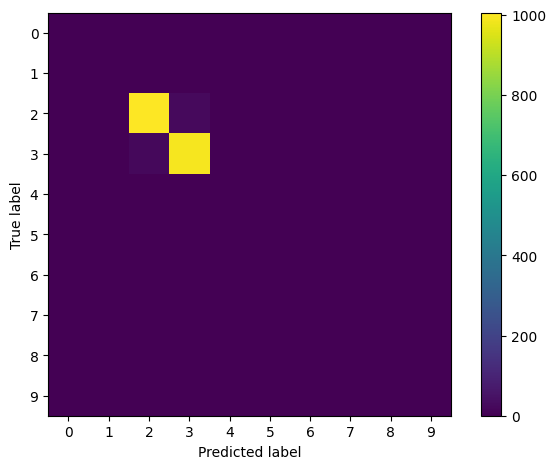

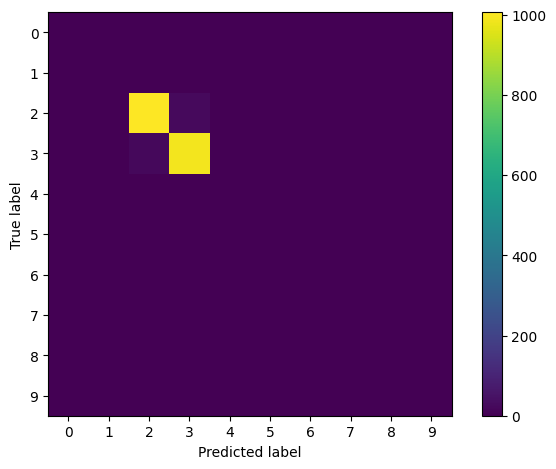

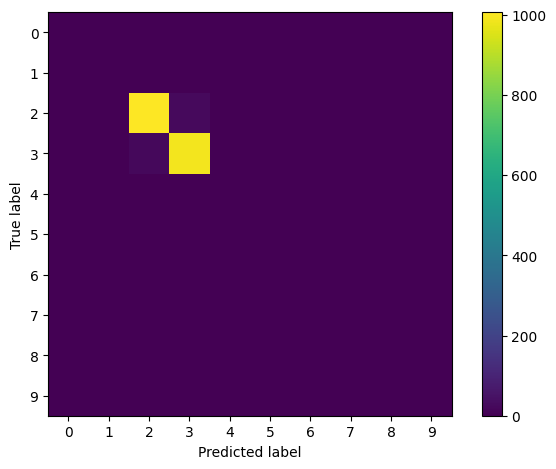

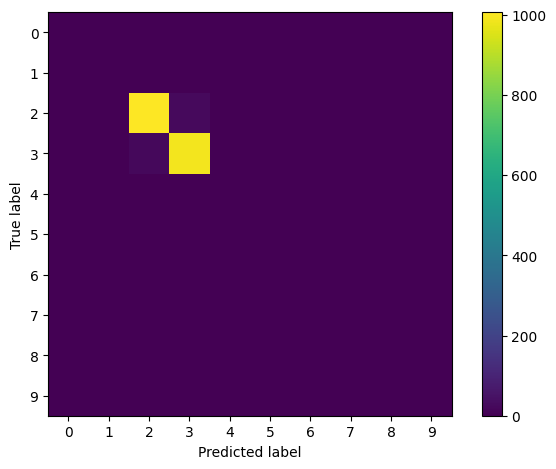

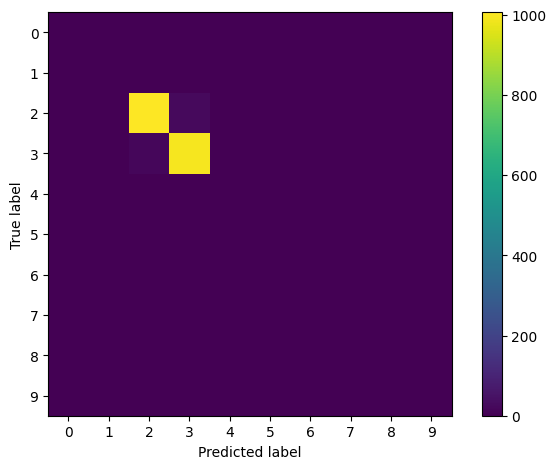

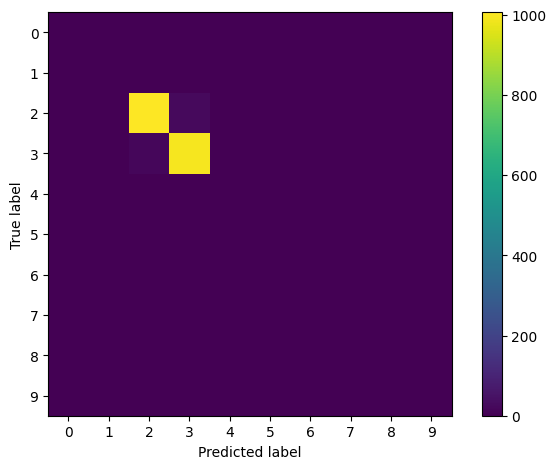

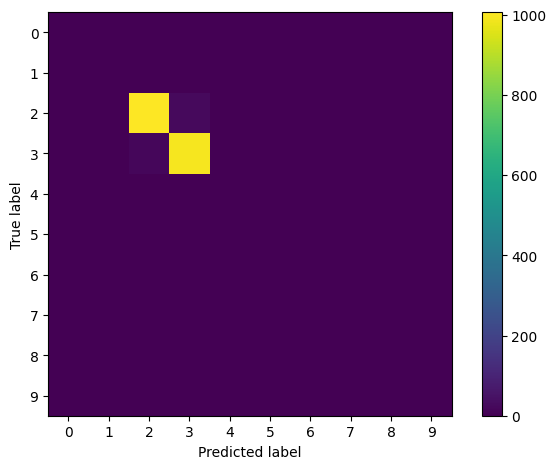

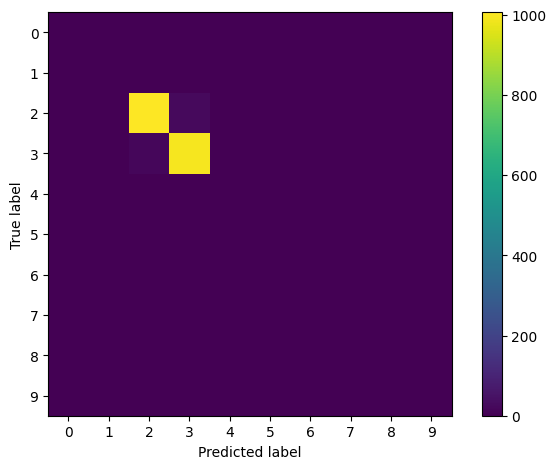

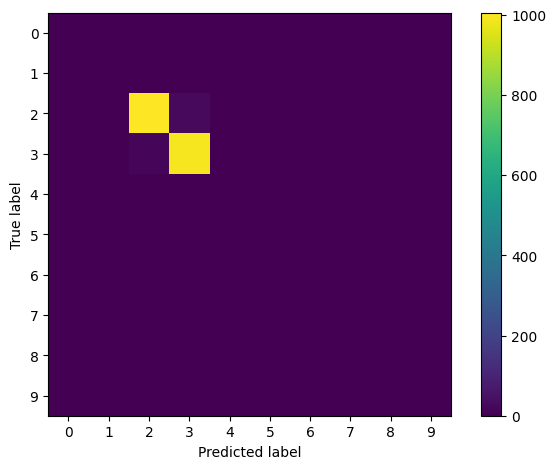

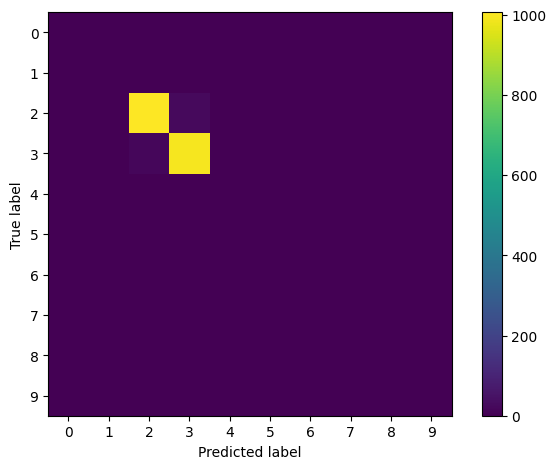

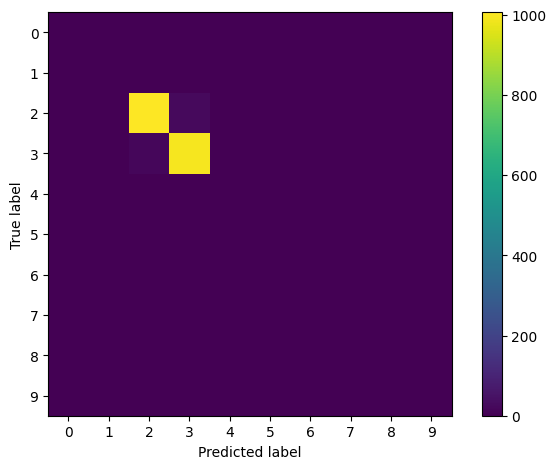

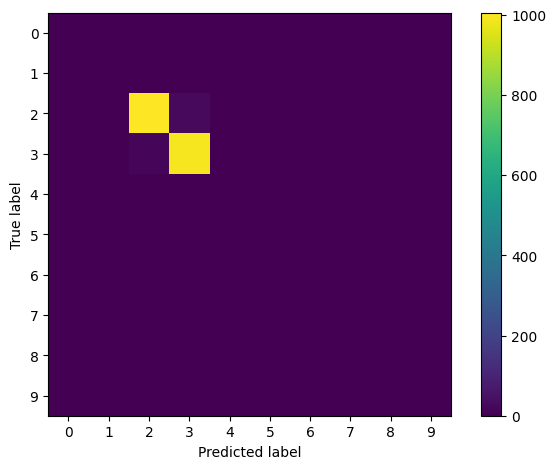

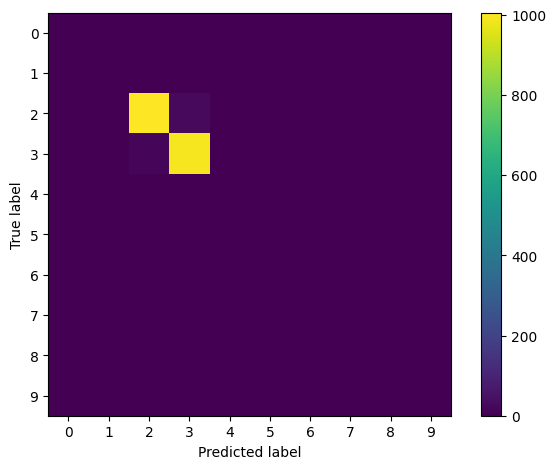

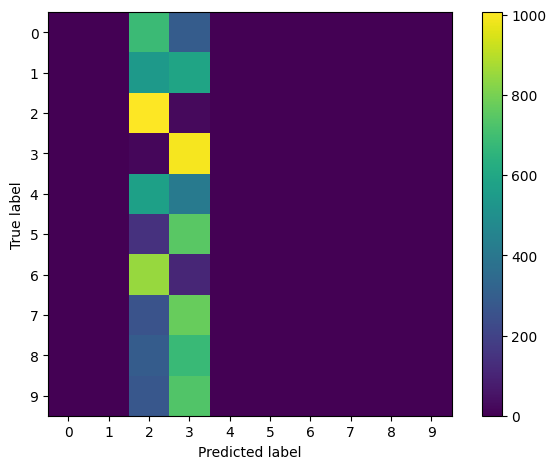

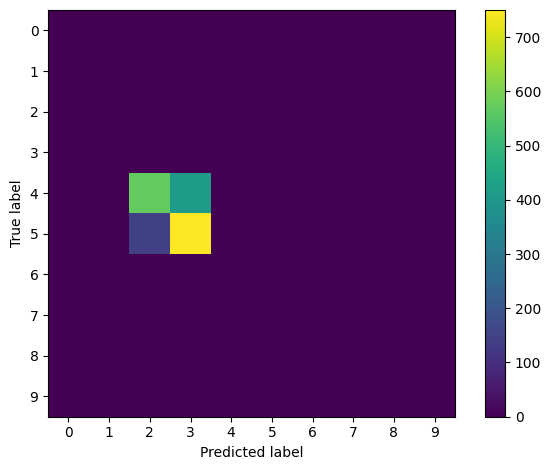

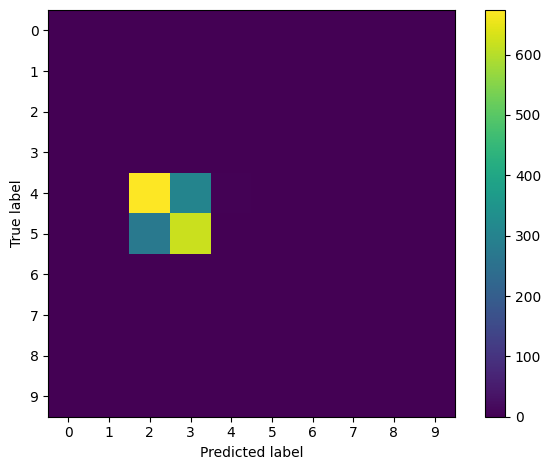

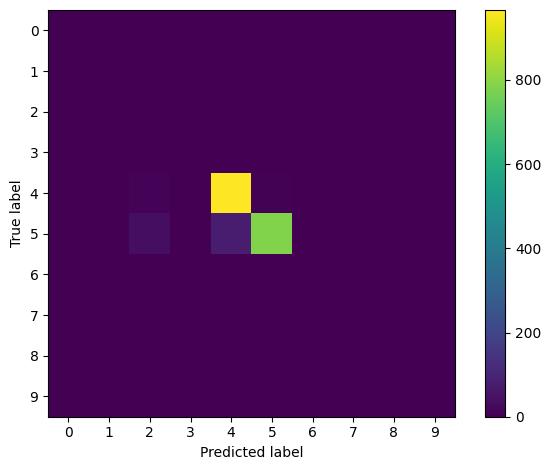

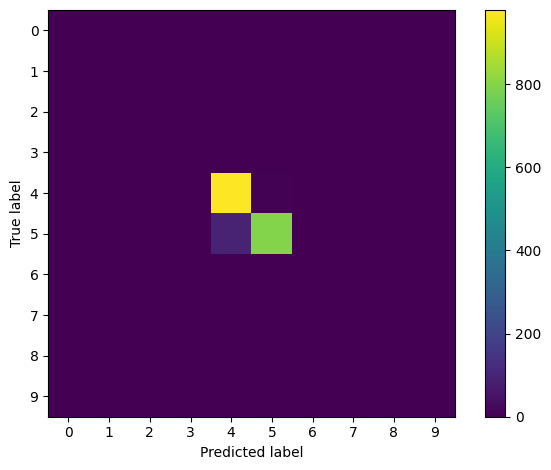

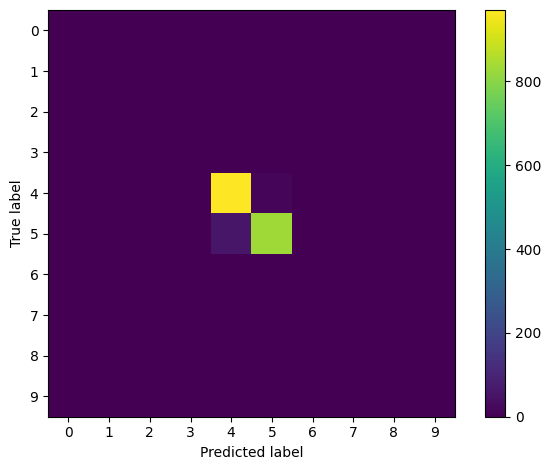

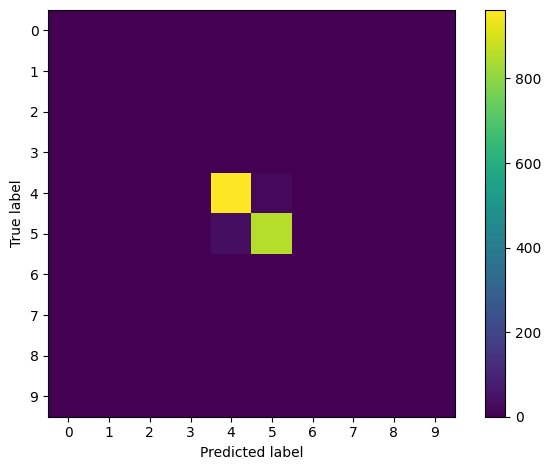

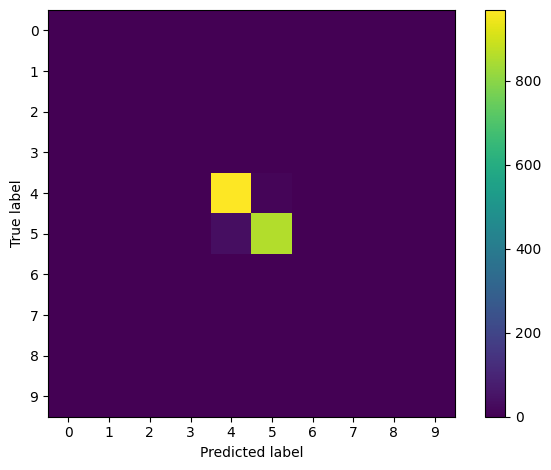

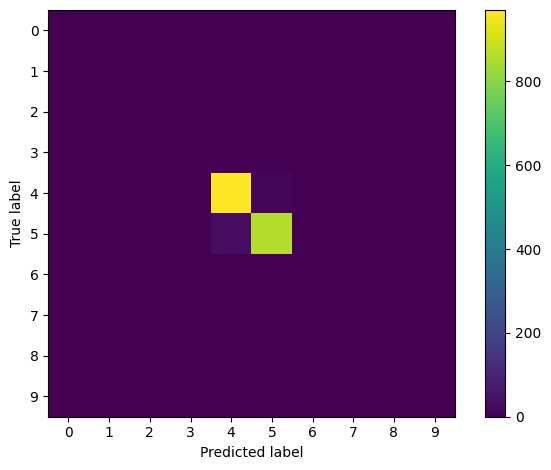

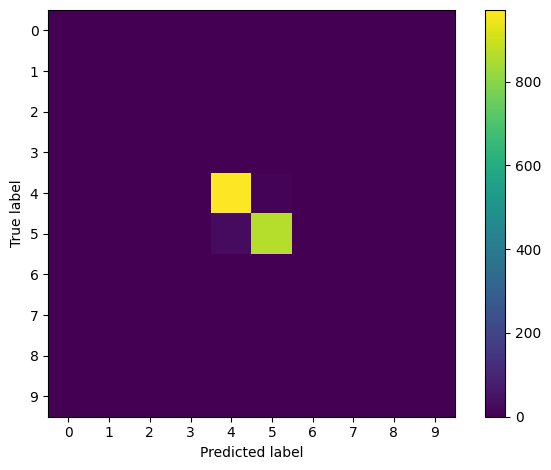

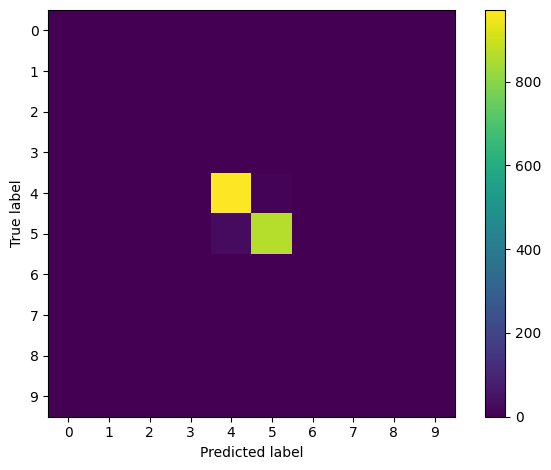

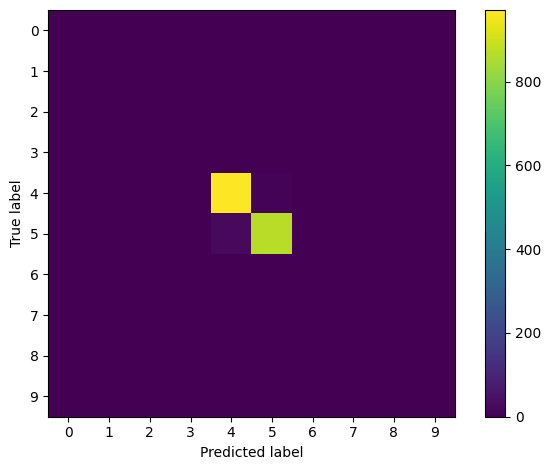

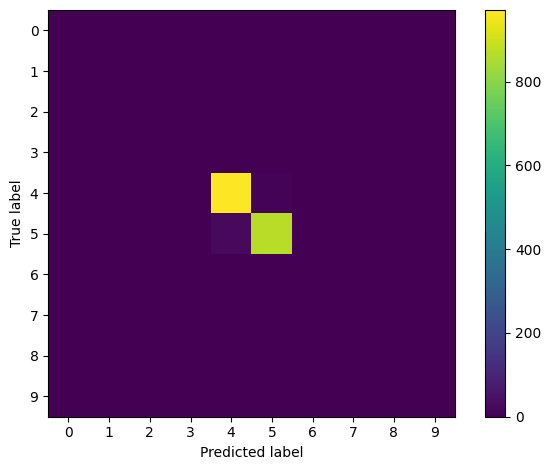

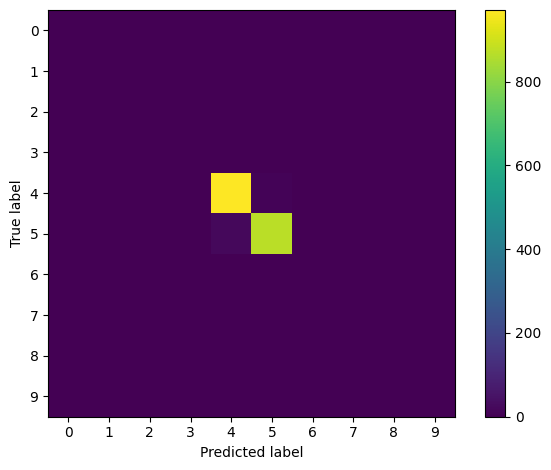

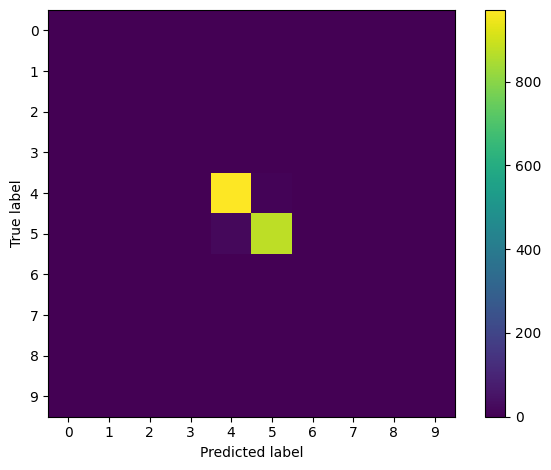

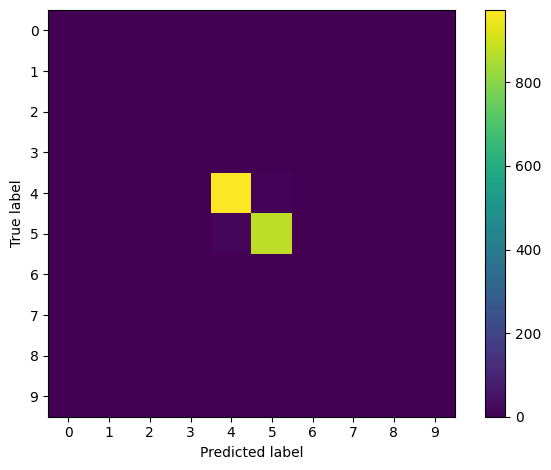

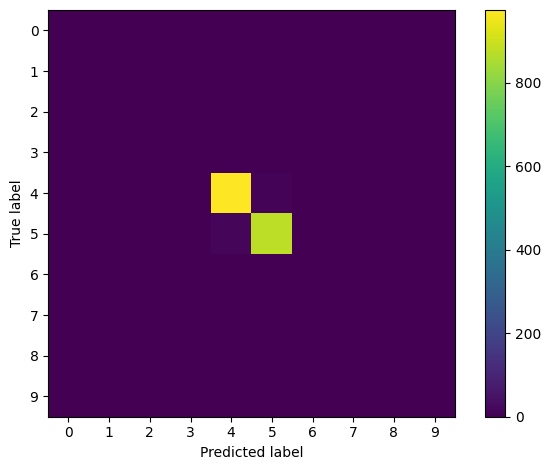

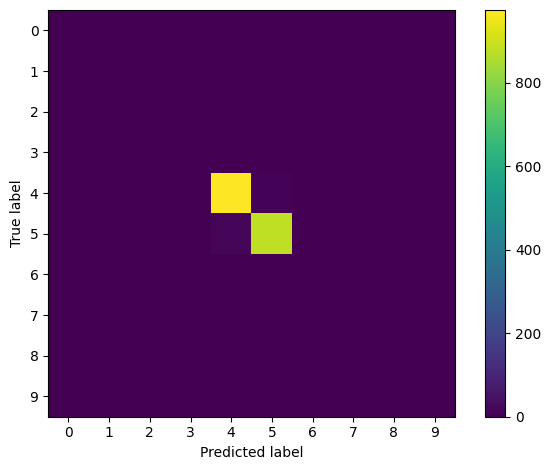

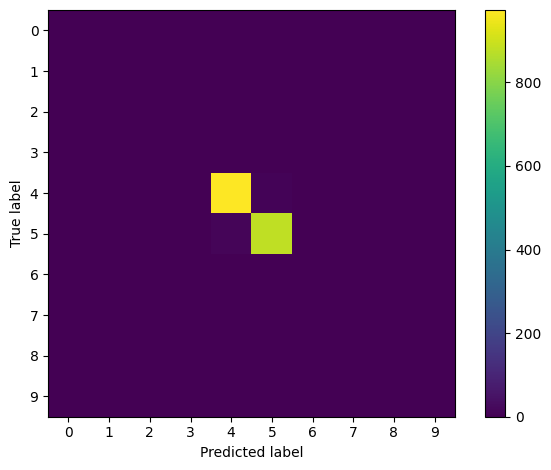

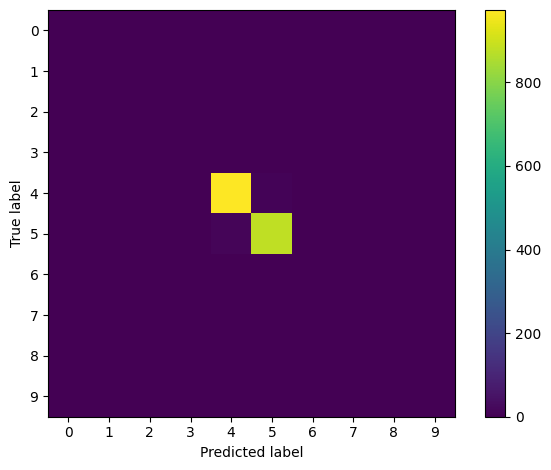

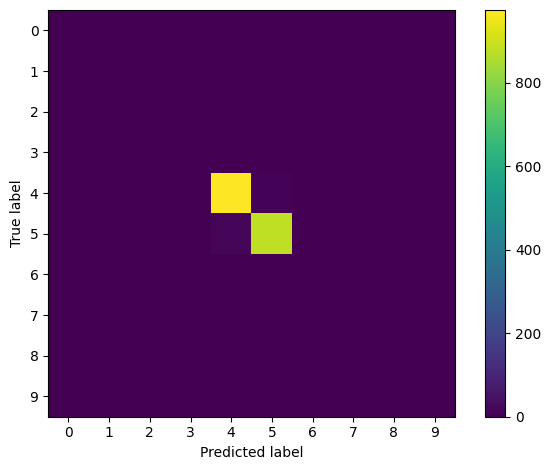

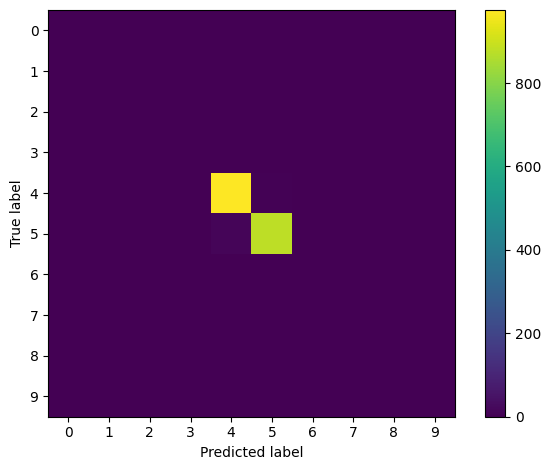

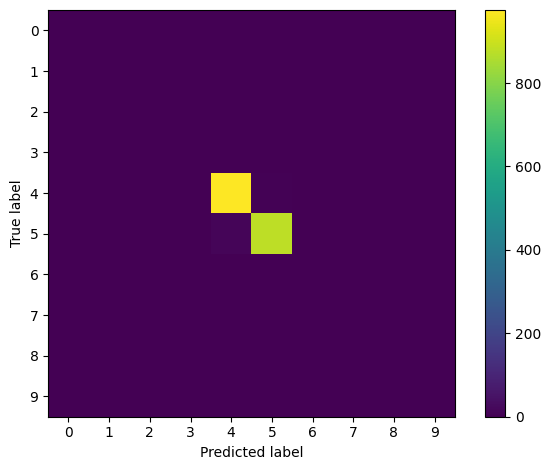

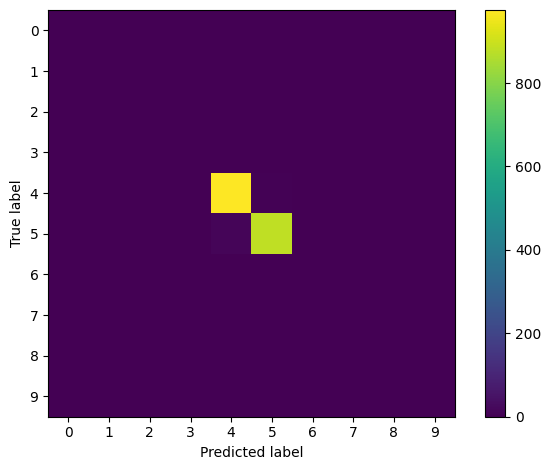

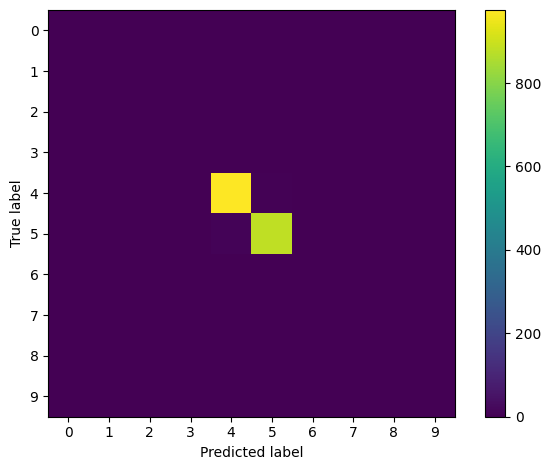

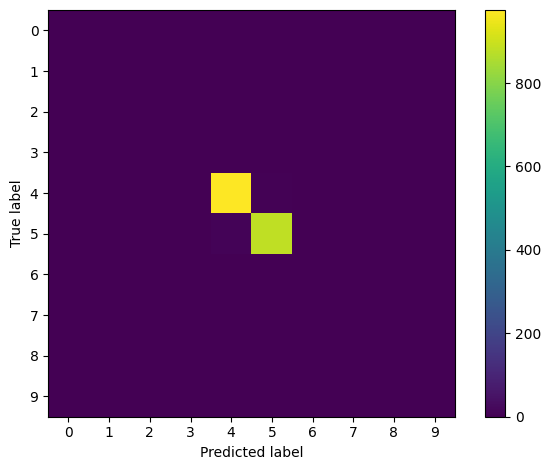

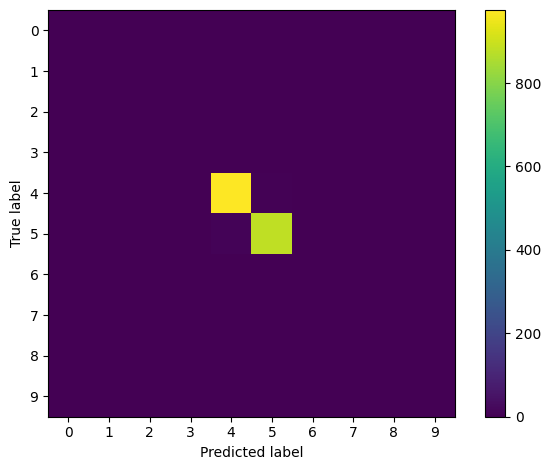

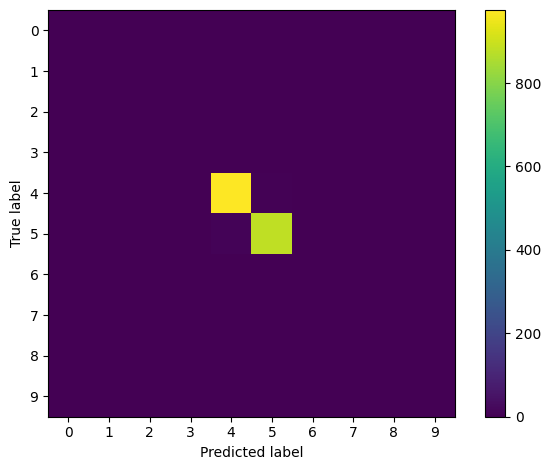

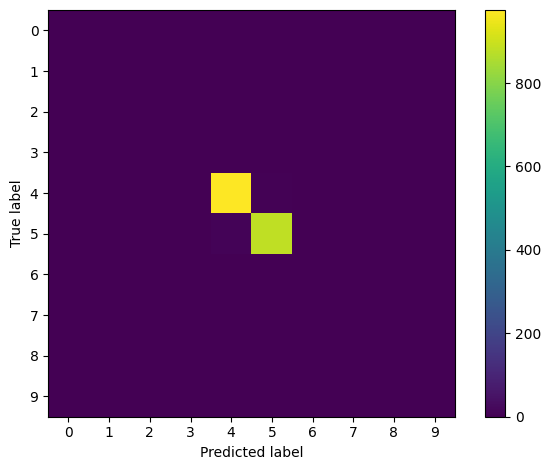

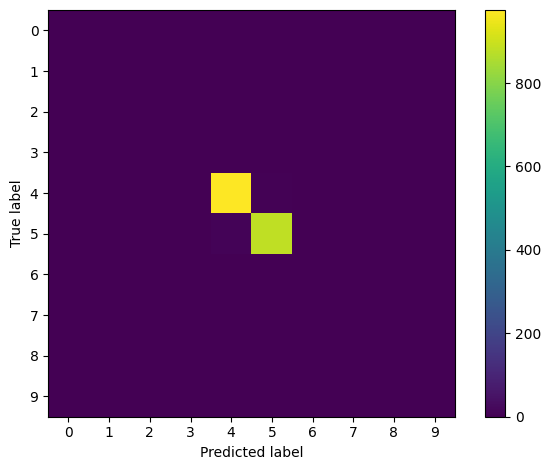

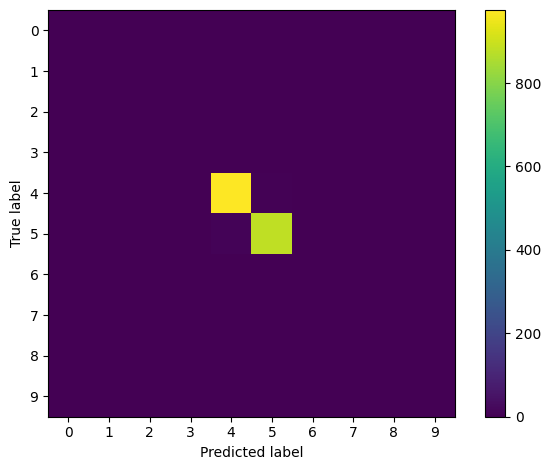

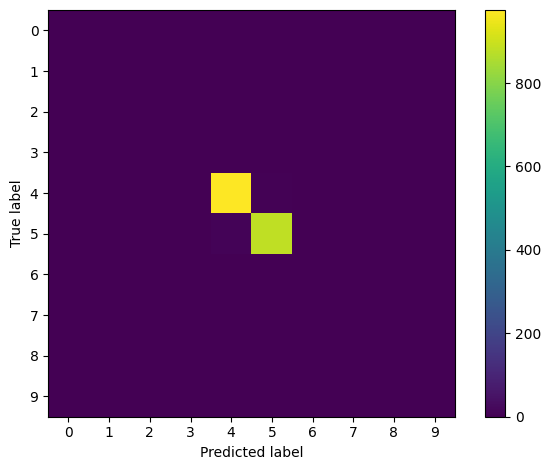

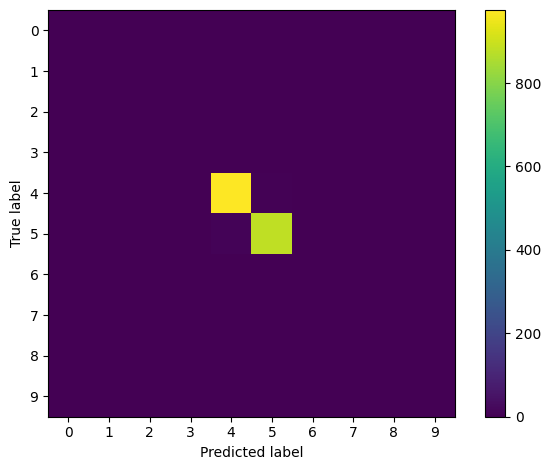

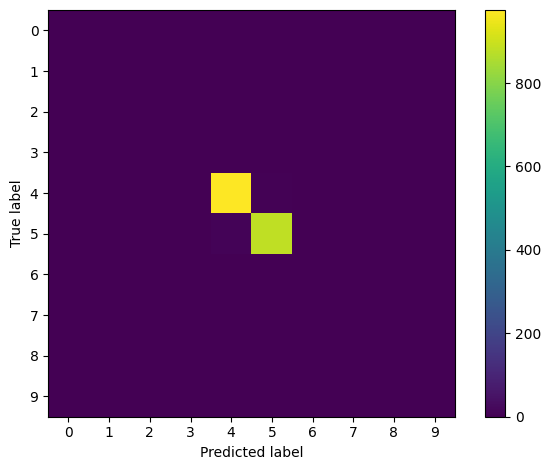

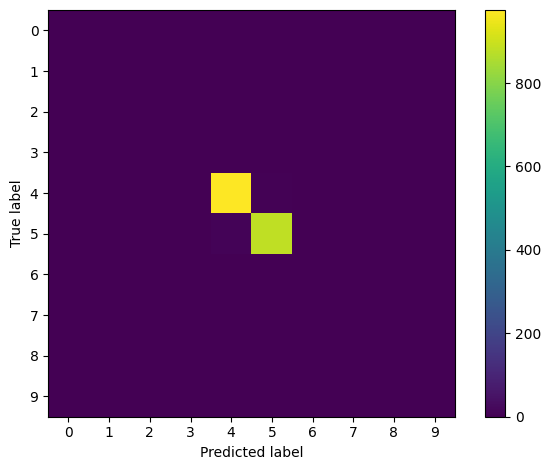

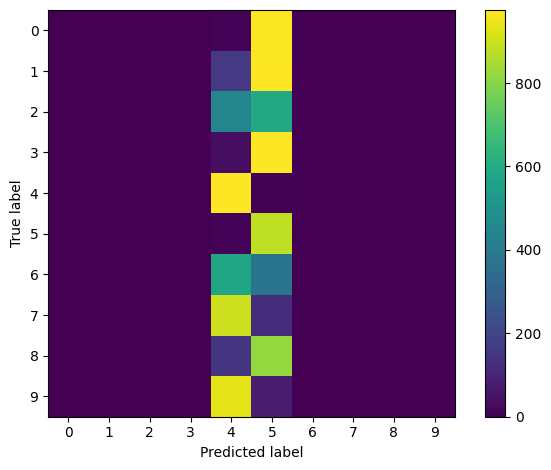

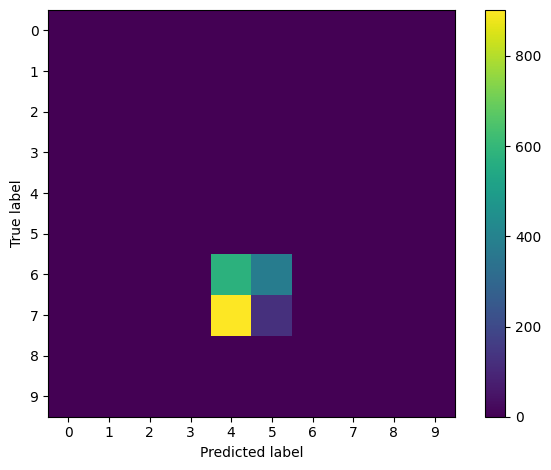

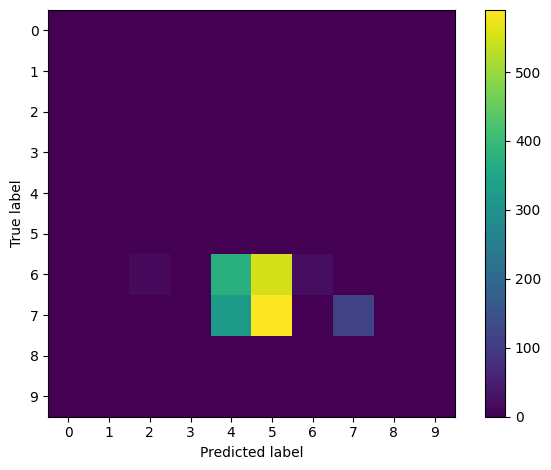

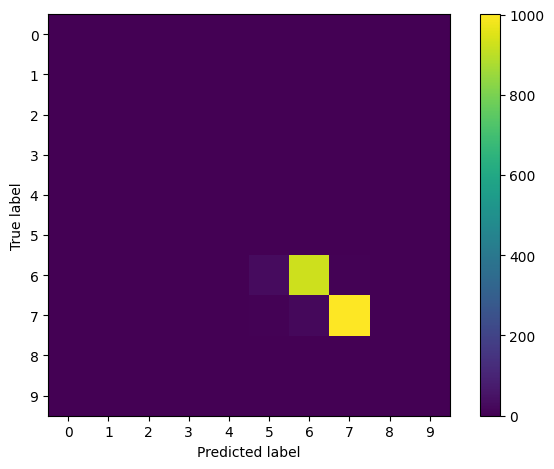

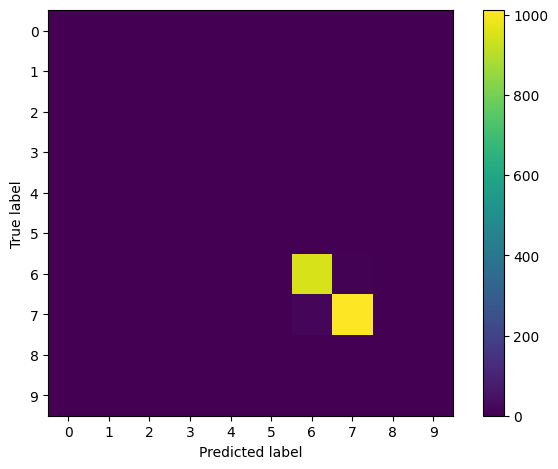

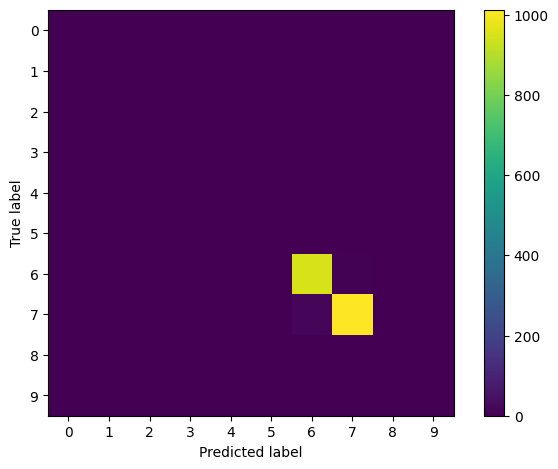

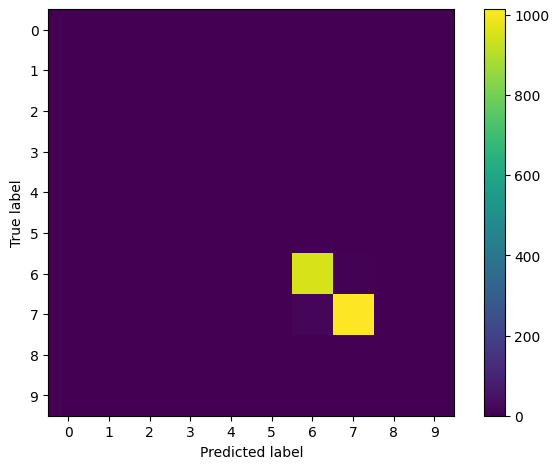

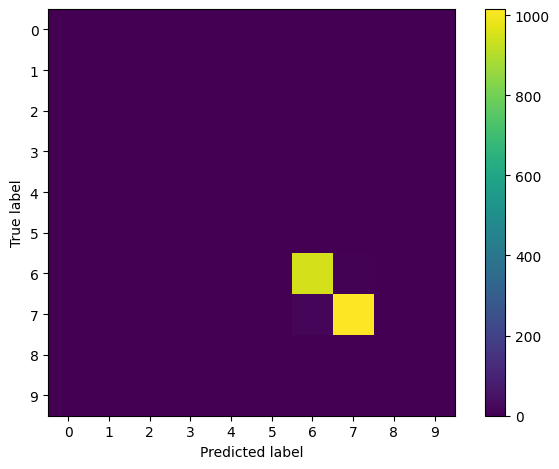

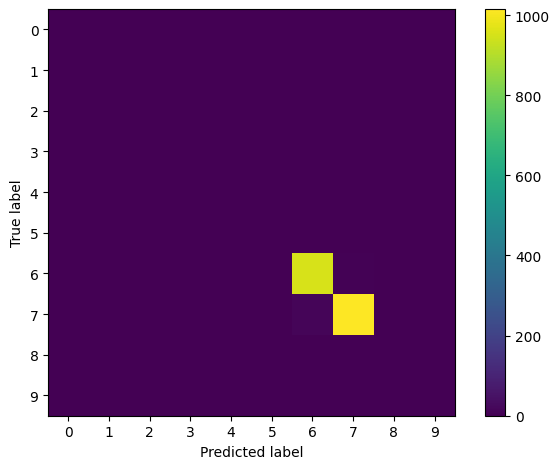

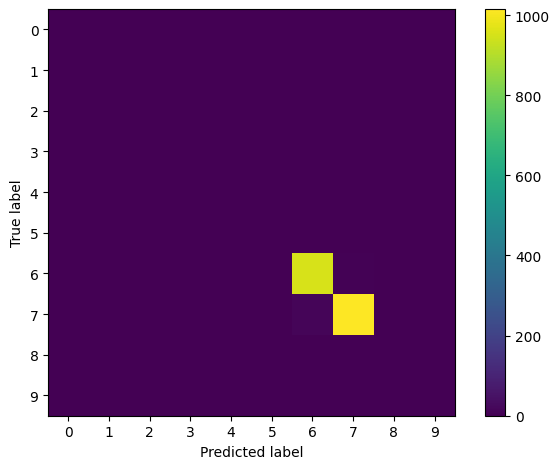

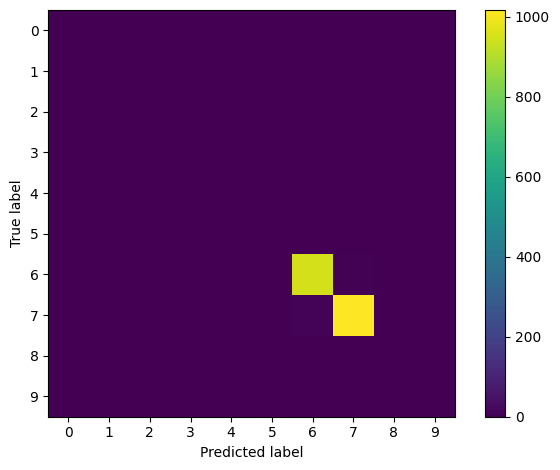

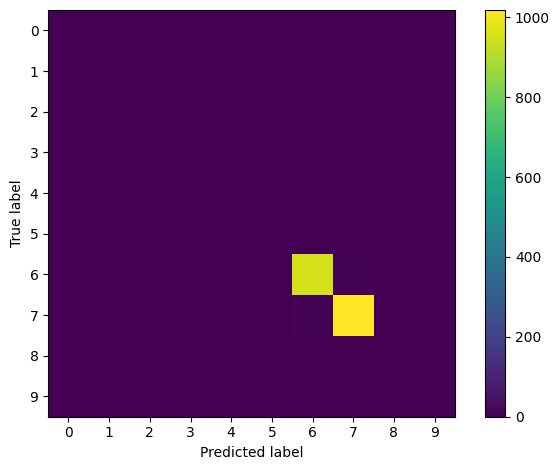

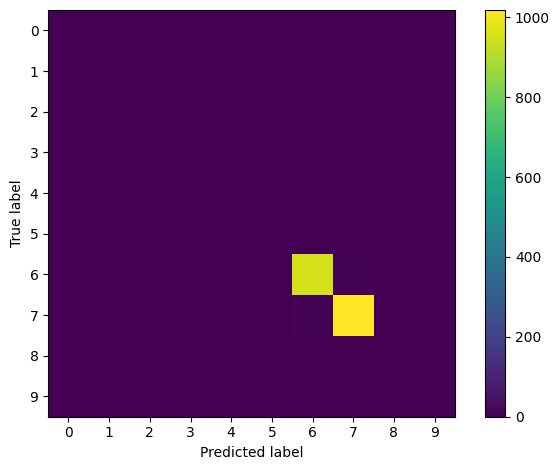

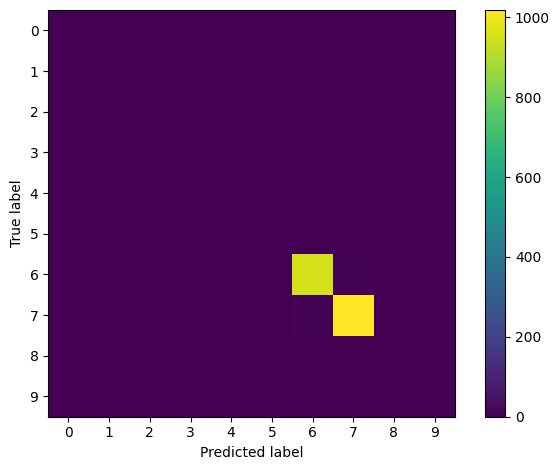

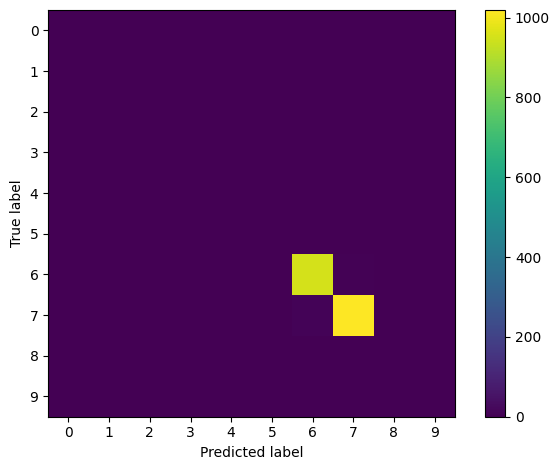

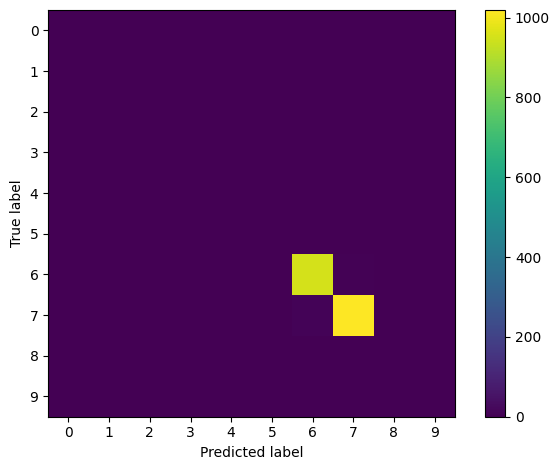

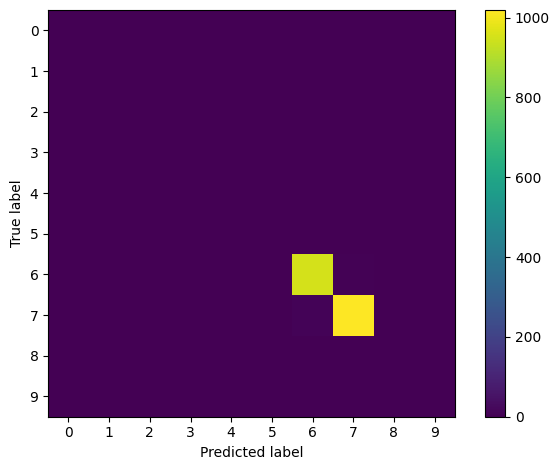

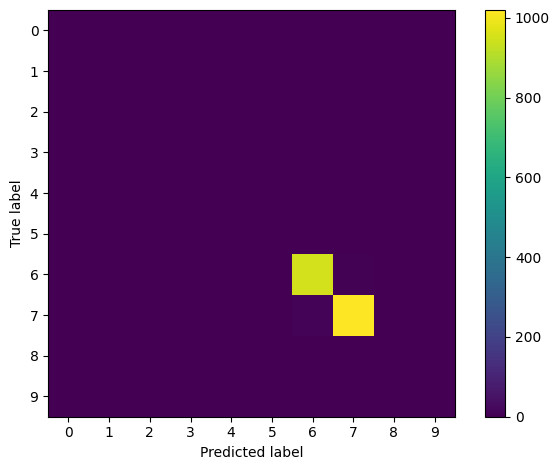

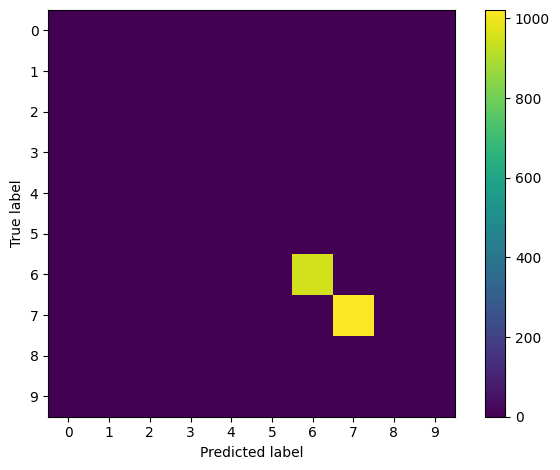

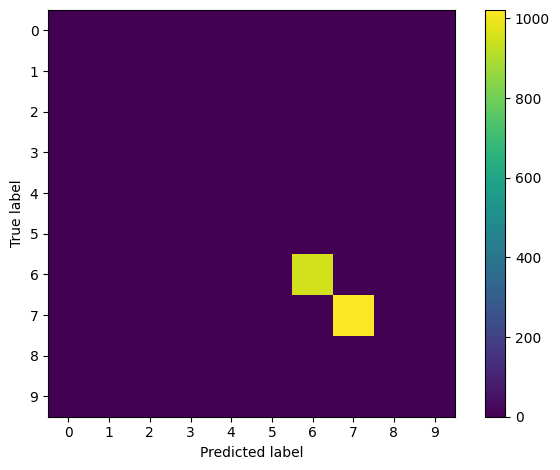

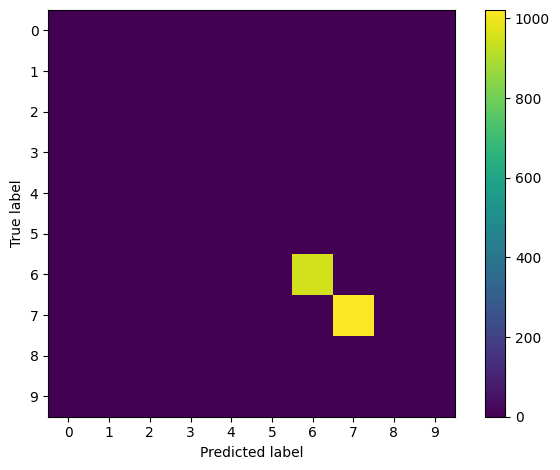

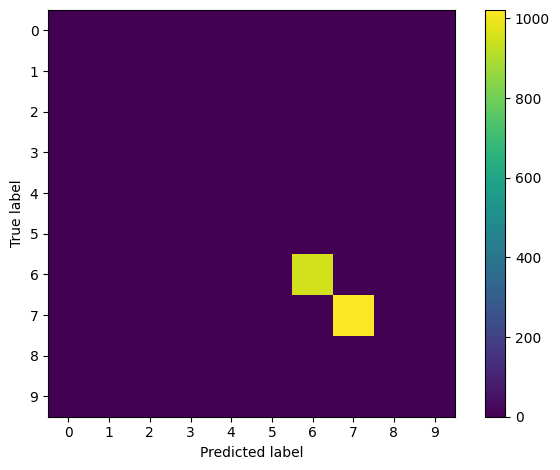

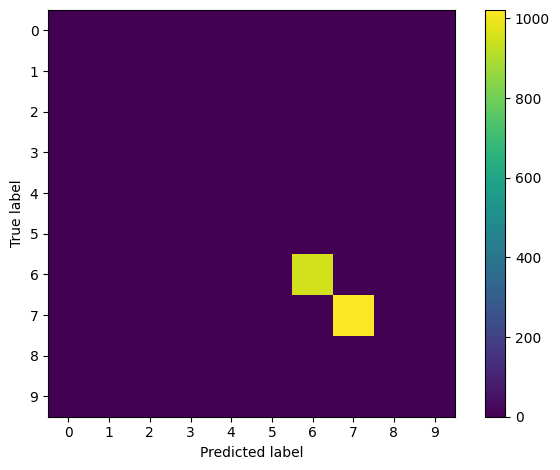

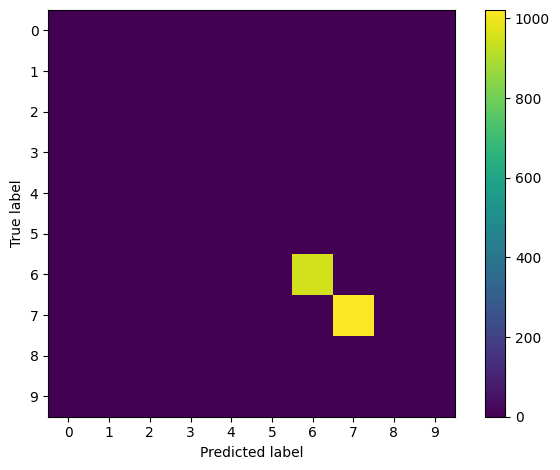

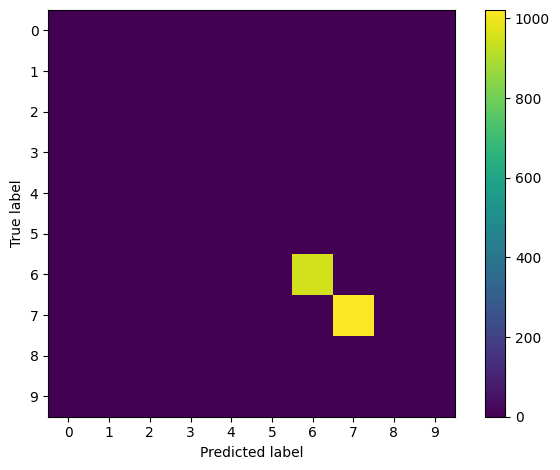

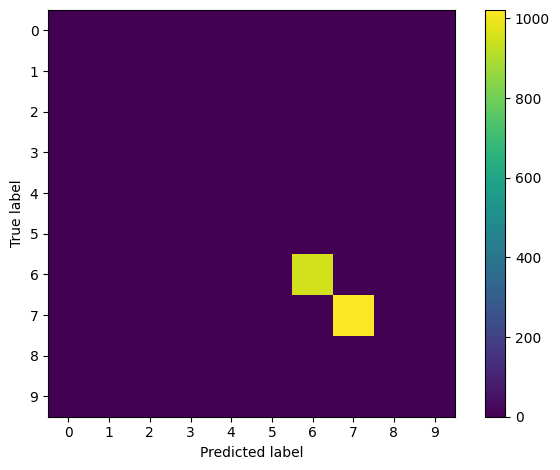

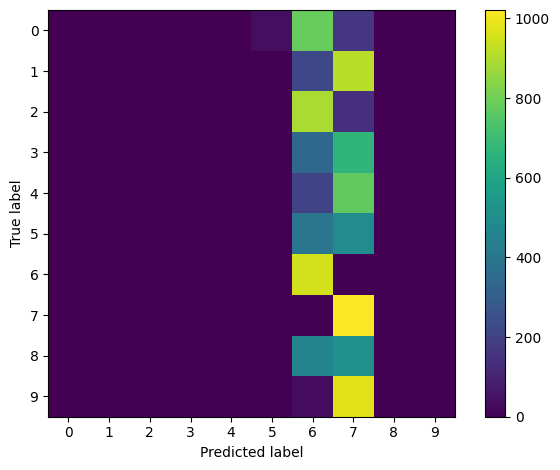

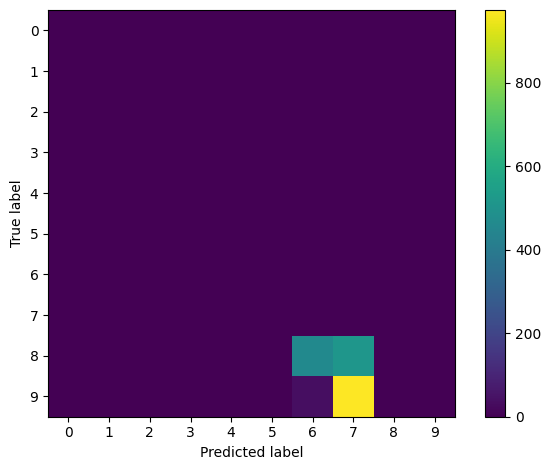

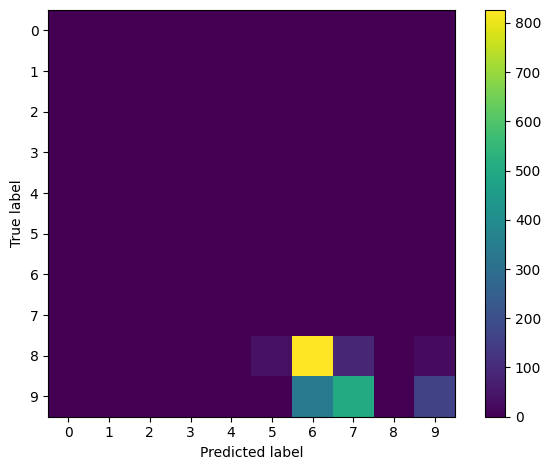

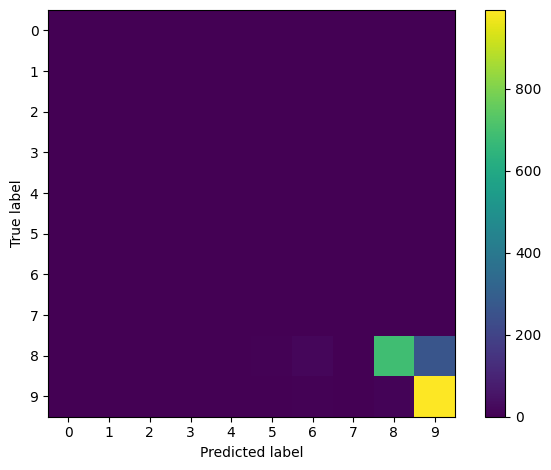

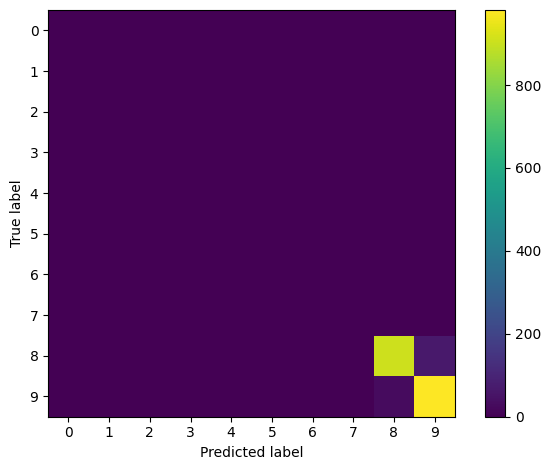

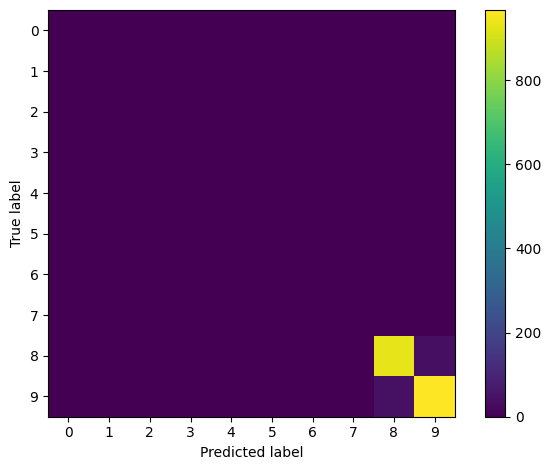

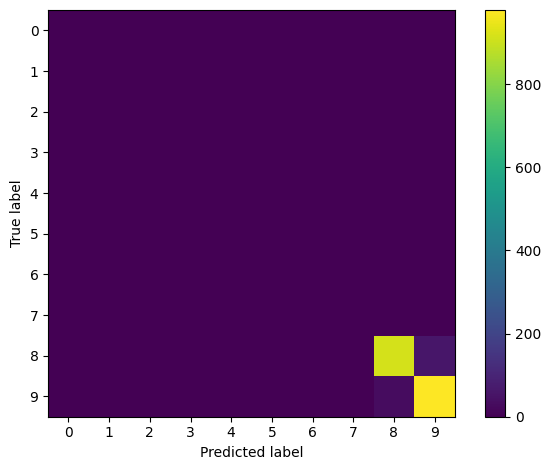

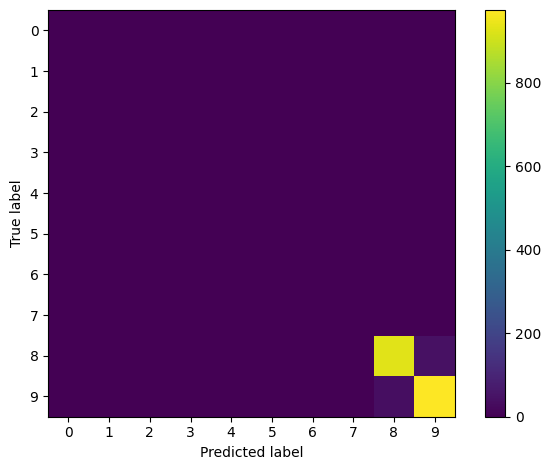

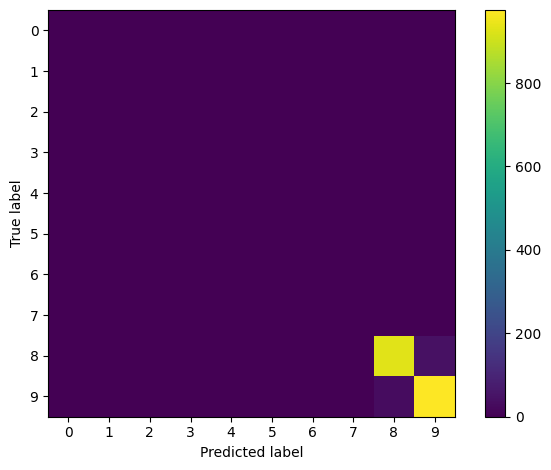

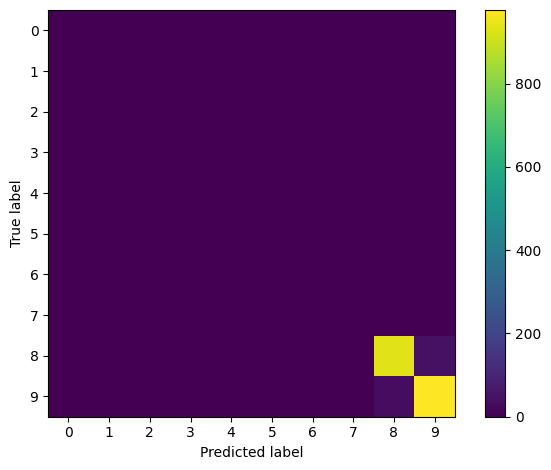

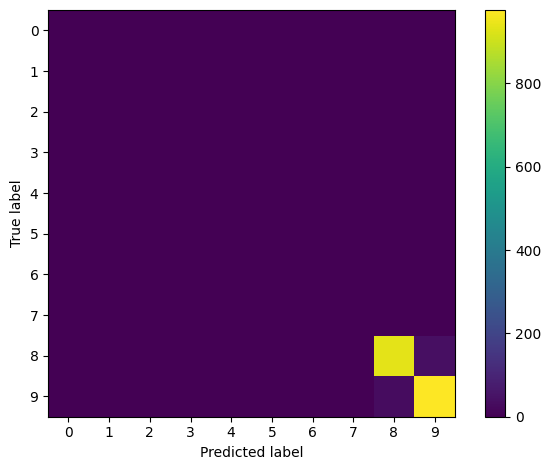

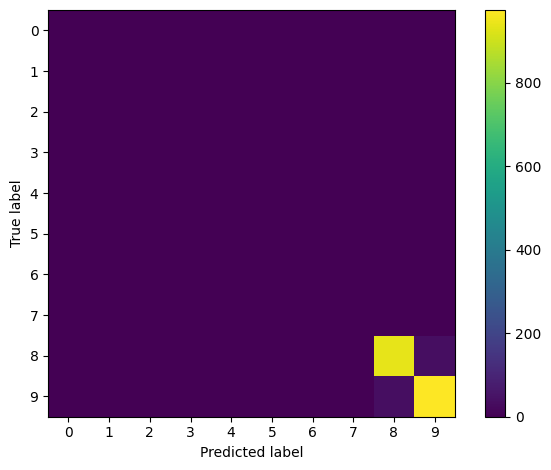

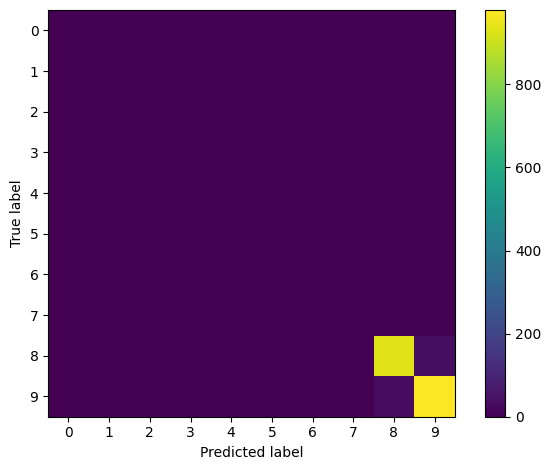

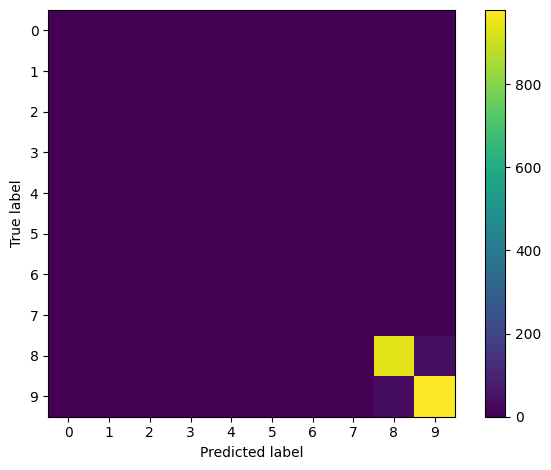

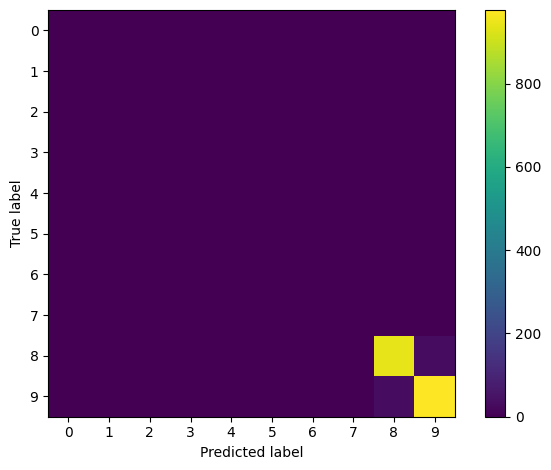

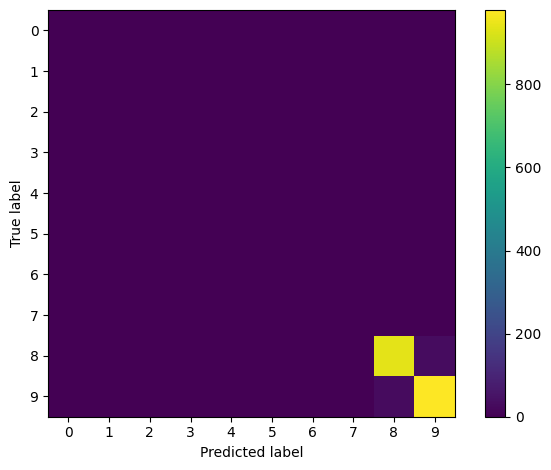

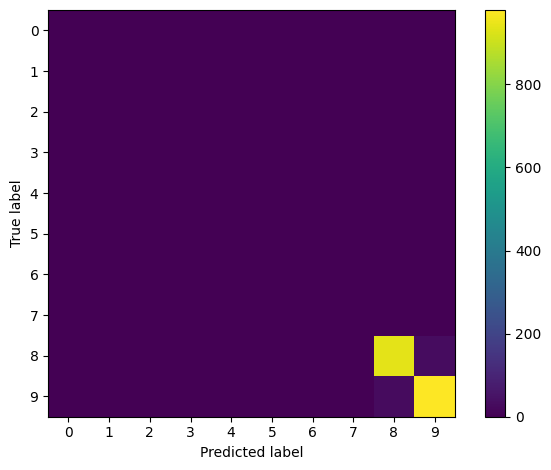

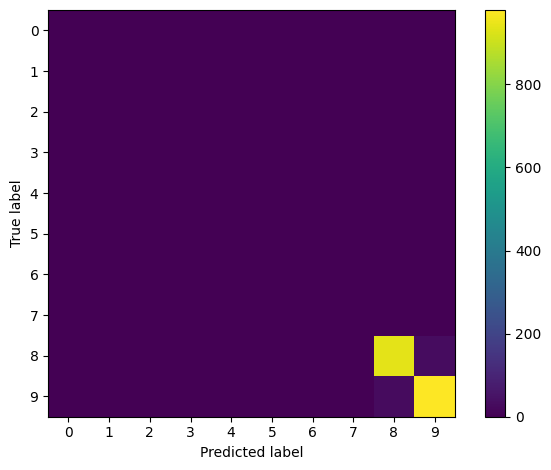

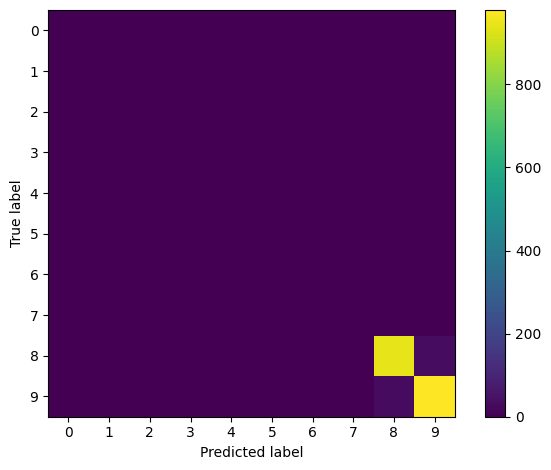

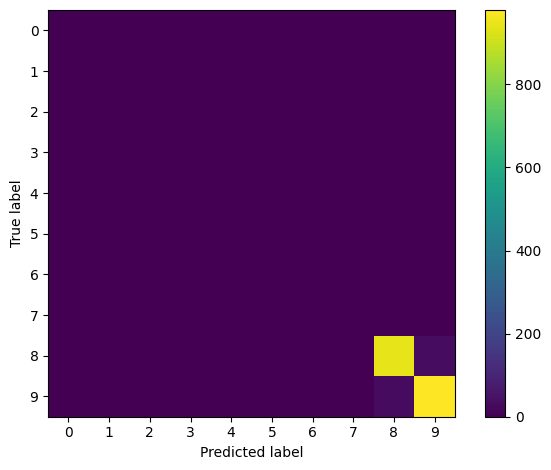

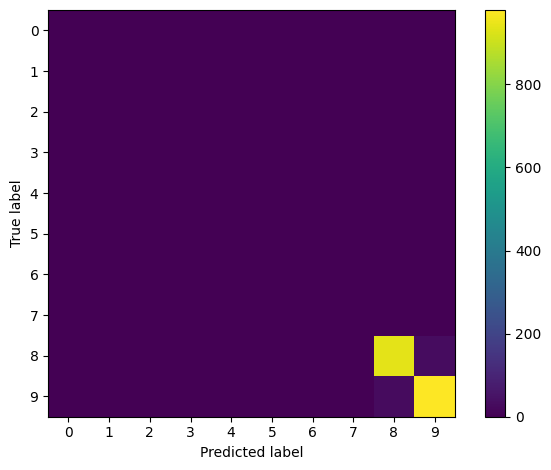

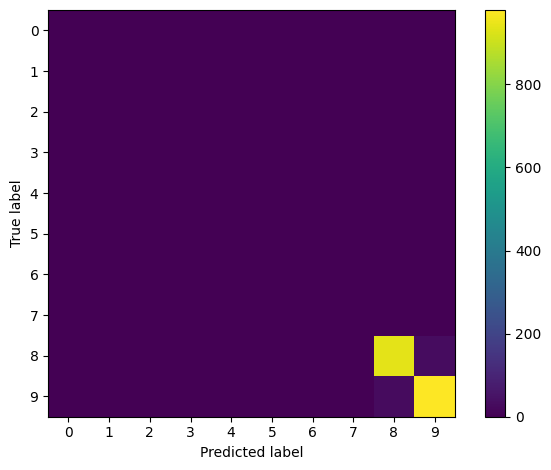

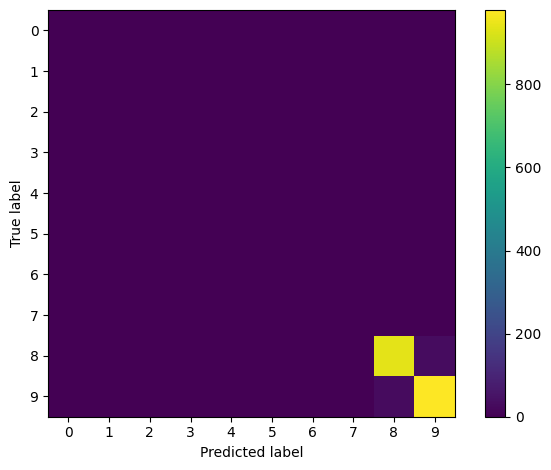

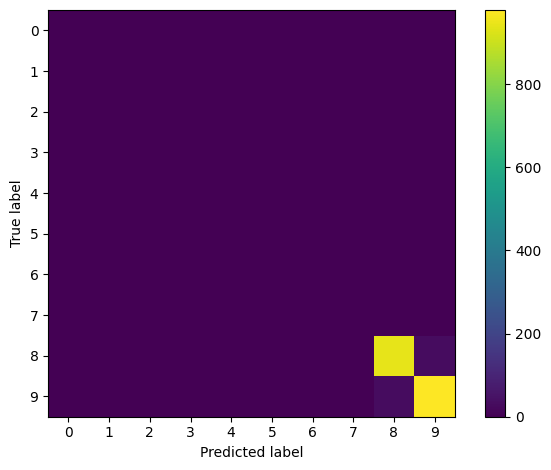

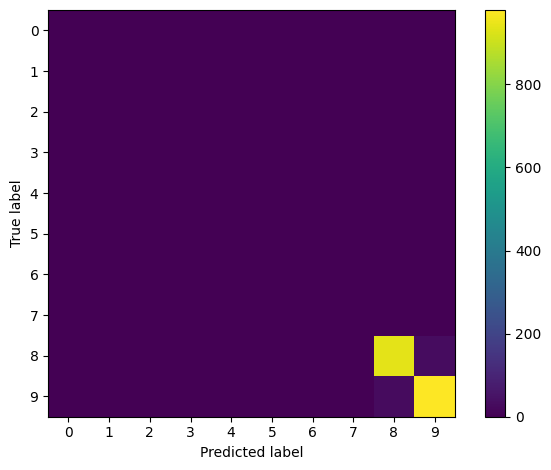

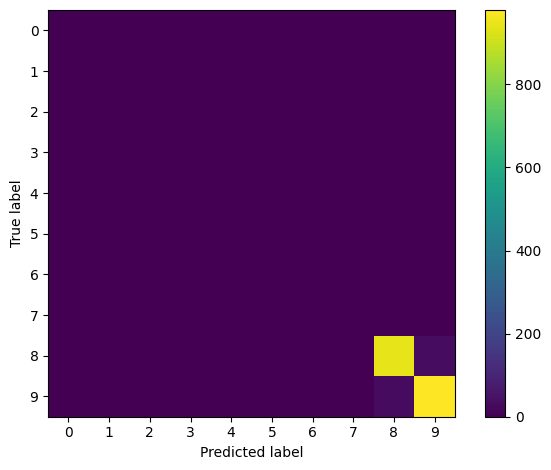

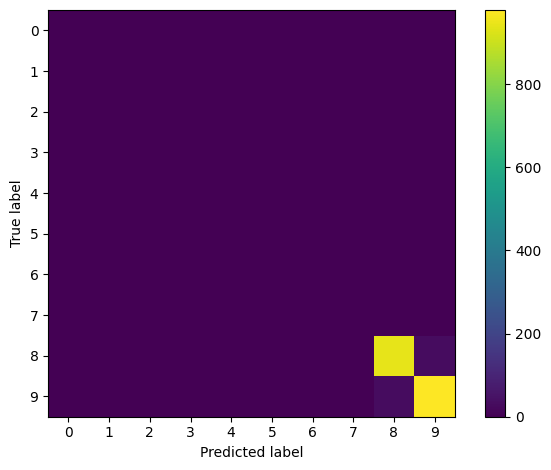

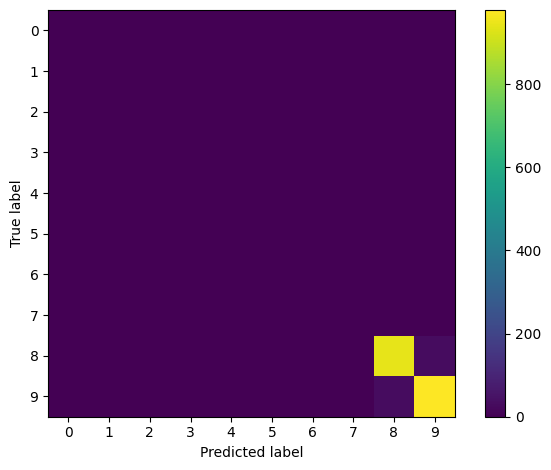

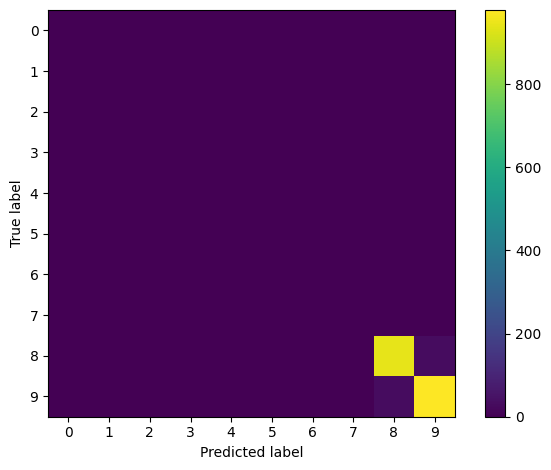

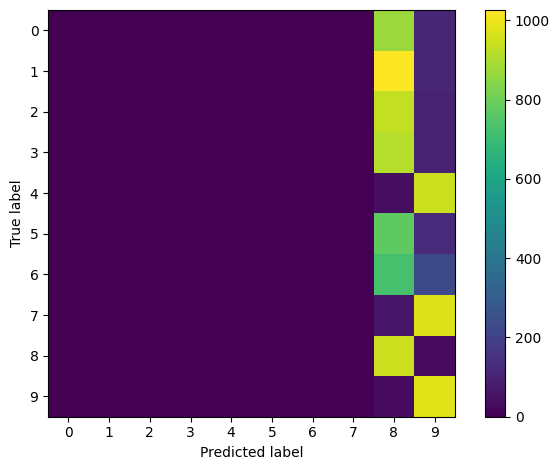

In [4]:
cl_strategy = Naive(
    model,
    optimizer,
    criterion,
    train_mb_size=BATCH_SIZE,
    train_epochs=100,
    eval_mb_size=BATCH_SIZE,
    device=device,
    eval_every=1,
    evaluator = eval_plugin,
    plugins=[EarlyStoppingPlugin(5, "test_stream")],
)

# train and test loop
naive_results = []
for train_task, test_task in zip(train_stream, test_stream):
  print()
  print()
  print("Current Classes: ", train_task.classes_in_this_experience)
  cl_strategy.train(train_task, eval_streams=[test_task])
  naive_results.append(cl_strategy.eval(test_stream))

## GDUMB 

In [ ]:
from avalanche.training.plugins import GDumbPlugin

# Prepare for training & testing
reset_parameters(model)

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


# Continual learning strategy with default logger
cl_strategy = Naive(
    model,
    optimizer,
    criterion,
    train_mb_size=BATCH_SIZE,
    train_epochs=100,
    eval_mb_size=BATCH_SIZE,
    device=device,
    eval_every=1,
    evaluator = eval_plugin,
    plugins=[EarlyStoppingPlugin(5, "test_stream"), GDumbPlugin(mem_size=500)],
)

# train and test loop
gdumb_results = []
for train_task, test_task in zip(train_stream, test_stream):
  print()
  print()
  print("Current Classes: ", train_task.classes_in_this_experience)
  cl_strategy.train(train_task, eval_streams=[test_task])
  gdumb_results.append(cl_strategy.eval(test_stream))

/opt/conda/lib/python3.11/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)




Current Classes:  [0, 1]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00, 12.04it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 92.9248
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 3990.6328
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.9967
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.4347
	MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0019


/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x799209849450>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.6482
	CumulativeAccuracy/eval_phase/test_stream/Exp001 = 0.4950
	CumulativeAccuracy/eval_phase/test_stream/Exp002 = 0.2255
	CumulativeAccuracy/eval_phase/test_stream/Exp003 = 0.0047
	CumulativeAccuracy/eval_phase/test_stream/Exp004 = 0.0019
	CumulativeForgetting/eval_phase/test_stream/Exp000 = 0.3470
	CumulativeForgetting/eval_phase/test_stream/Exp001 = 0.0662
	CumulativeForgetting/eval_phase/test_stream/Exp002 = -0.2234
	CumulativeForgetting/eval_phase/test_stream/Exp003 = 0.0648
	CumulativeForgetting/eval_phase/test_stream/Exp004 = 0.0808
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3990.6328
	Loss_Stream/eval_phase/test_stream/Task000 = 2.4347
	StreamForgetting/eval_phase/test_stream = 0.9967
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0019
100%|██████████| 1

/opt/conda/lib/python3.11/site-packages/avalanche/evaluation/metric_utils.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x7992050c4510>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.9967
	CumulativeAccuracy/eval_phase/test_stream/Exp001 = 0.9967
	CumulativeAccuracy/eval_phase/test_stream/Exp002 = 0.9967
	CumulativeAccuracy/eval_phase/test_stream/Exp003 = 0.9967
	CumulativeAccuracy/eval_phase/test_stream/Exp004 = 0.9967
	CumulativeForgetting/eval_phase/test_stream/Exp000 = -0.0014
	CumulativeForgetting/eval_phase/test_stream/Exp001 = -0.4355
	CumulativeForgetting/eval_phase/test_stream/Exp002 = -0.9946
	CumulativeForgetting/eval_phase/test_stream/Exp003 = -0.9272
	CumulativeForgetting/eval_phase/test_stream/Exp004 = -0.9140
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4022.5195
	Loss_Stream/eval_phase/test_stream/Task000 = 0.2495
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.9967
100%|█████████